# Introduction to Pandas
Pandas is an extensive, powerful library for manipulating and analyzing serial and/or tabular data structures with column and row labels. It comes with a suite of built-in statistical functions, time series construction and analysis tools, grouping and sorting functions, hierarchical indexing functions, and even some built-in plotting methods. The data structures that Pandas is built around are highly mutable, adaptable to many data types, and can be loaded from or saved to a wide variety of text, binary, or database files. Several of Python's machine learning libraries and large language modeling packages are built around pandas data structures, especially SciKitLearn and TensorFlow. [Some accelerated operations are supported using the `bottleneck` and `numexpr` libraries.](https://pandas.pydata.org/docs/user_guide/basics.html#accelerated-operations)

In the interest of ensuring you know about the best tools for your data, I should mention that Pandas has a couple of potentially deal-breaking limitations: support for data structures with >2 dimensions is limited and hard to use, and there is little native support for parallelization. If you have N-dimensional data where N>2, [`Xarray` is probably the better choice of software](https://xarray.dev/). Similarly, if speed is enough of an issue that you need to distribute your array processing over multiple CPUs or nodes, including `bottleneck` and `numexpr` may help, but [you might consider `Polars` instead](https://docs.pola.rs/).

In [1]:
import pandas as pd
import numpy as np

### Pandas Object Classes
Most data structures you will use in Pandas will be one of the following two object classes:

1. `Series`: a 1D array that can optionally have an "index" assigned to every entry and a "name" for the whole distinct from the variable name in your code. The indexes (and name) need only to be hashable; they don't have to be numeric or even unique. Data can also be of any type.
2. `DataFrame`: a 2D array or table of values where every row and column can be assigned a label and/or index; like a `dict` of `Series` stacked column-wise, but with different data selection syntax. Arithmetic operations can be performed along either axis, where axis=0 typically refers to row-wise operations and axis=1 refers to column-wise operations. The data type of each column is determined separately. DataFrames can also be grouped by column or row values with the `groupby()` method, or rearranged with the `pivot()` or `pivot_table()` methods, such that the result is hierarchical, like a 2D projection of higher-dimensional data structures.

These are the workhorses of data analysis with Pandas. Other Pandas data structures you may encounter include:

3. `Index`: the Pandas datatype of attributes that store the row and column labels of a DataFrame or Series. You could convert a 1D array to an `Index` type object or use a Pandas function to produce an `Index` object directly, but more often you will extract `Index` objects from existing Series or DataFrames and, if needed, convert them to NumPy arrays or lists. Many of their attributes and methods are shared with Series and NumPy arrays, and a few methods are also shared with DataFrames.
4. `DataFrameGroupBy` (abbr. GroupBy): a structure returned by the `df.groupby()` method. It may look like the input DataFrame sorted by the values of the column label(s) entered as arguments, but for any basic function or statistical method called on this object, the number of return values will equal the number of unique values or value combinations from the column(s) used to group the DataFrame contents. If two or more labels are used for grouping, the result will be hierarchical, and will have MultiIndexes instead of just Indexes.
5. `MultiIndex`: the hierarchical analogue of `Index` for GroupBy objects and other hierarchical DataFrames. Each list item is a tuple instead of a string or scalar value. We may talk about MultiIndexing and hierarchical DataFrames late in this course because, in my view, their complexity makes their usage awkward and error-prone, but if I run out of time the subject may be cut entirely. If you need such functionality and don't like the constraints of working strictly in 2D, Xarray might be a better alternative.
6. `NumpyExtensionArray`, `DatetimeArray`, and `TimedeltaArray`: to extend NumPy functionality, especially to time series, Pandas includes an `array(data, dtype=dtype)` function that can be used to declare simple arrays or store timestamps or time increments depending on what you enter for the `dtype` kwarg. Most familiar datatypes will produce an array of the `NumpyExtensionArray`, but if you set `dtype` equal to `'datetime64[ns]'` or `'timedelta64[ns]'`, the resulting array will be of `DatetimeArray` or `TimedeltaArray` type, respectively.
7. `Categorical`: an R/S+-like way to store categorical data, i.e. data that take a limited number of values and are usually non-numeric. This datatype doesn't have many attributes or methods, and does not allow mathematical operations, but it is an efficient way to store a Series or column in a DataFrame where a limited number of values recur often.

DataFrames are the primary structure that Pandas is designed to work with, so we'll focus on those. **Functions that work on a DataFrame will also work on a Series unless they explicitly require multiple columns.** For the sake of demonstration, however, I will mock up a couple of example Series and DataFrames.

Series construction is simple: just call `pandas.Series()`. It is best if you can provide at least a 1D data array/list, if not also a corresponding list of indexes—for the same reason that allocating and then replacing values in a NumPy array is faster than appending to a list—but it is possible to create an empty Series and fill it later. If you provide the data but no index list, indexes will be assigned automatically.

In [5]:
ser1 = pd.Series([1,2,3], index=['a','b','c'], name='abc')
print(ser1)

a    1
b    2
c    3
Name: abc, dtype: int64


Note that the left column changes depending on whether we include the index kwarg (default index is 0-based), and that you can optionally assign the series a name.

The indexes also do not have to be numeric. They can be letters or even datatime objects.

In [23]:
#from datetime import datetime as dttm
sunrises= ['2023-12-21 08:34:00',
           '2023-12-31 08:36:00',
           '2024-01-11 08:31:00']
daylens = [7.01583, 7.11306, 7.46278]
srt = pd.to_datetime(sunrises,
                     format="%Y-%m-%d %H:%M:%S")
#much easier to use pandas to convert to datetime objects than
# to go through the datetime module - more on this later
print(srt)
print(pd.Series(daylens,index=srt))

DatetimeIndex(['2023-12-21 08:34:00', '2023-12-31 08:36:00',
               '2024-01-11 08:31:00'],
              dtype='datetime64[ns]', freq=None)
2023-12-21 08:34:00    7.01583
2023-12-31 08:36:00    7.11306
2024-01-11 08:31:00    7.46278
dtype: float64


Construction of a DataFrame is similar to that of a Series, but now you have the option to specify both the column names and the row indexes. If you leave these kwargs empty, pandas will assign 0-based integer indexes to both. Technically, even the first positional argument, the data, is optional. You can leave it blank and fill it later, although this is not recommended (see sub-section on initializing DataFrames with NumPy vs. pure Pandas).

In [52]:
dummy_df = pd.DataFrame(np.linspace(0.5,10,20).reshape(5,4),
                        columns=['a','b','c','d'])#, index=list(range(1,6)))
print(dummy_df)

     a    b    c     d
0  0.5  1.0  1.5   2.0
1  2.5  3.0  3.5   4.0
2  4.5  5.0  5.5   6.0
3  6.5  7.0  7.5   8.0
4  8.5  9.0  9.5  10.0


In [58]:
dummy_df.index.memory_usage(deep=True)

132

#### Basic Attributes
DataFrames and Series have more than a dozen attributes besides those used to select subsets of the data, and several hundred object methods to transform, aggregate, and broadcast data and functions thereof. We cannot possibly cover all the object methods, but I will do my best to cover the ones I have experience with and/or can demonstrate within the limits of the presentation format.

There are a small enough number of attributes that they can be listed here and in the upcoming section on data selection:
| Attribute Syntax | Value |
| --- | --- |
| `df.axes` | nested list of row & column indexes (labels) |
| `df.columns` | Index-type, list of column labels (add `.values` to get an array) |
| `df.index` | Index-type, list of row indexes (labels; add `.values` to get an array) |
| `df.dtypes` | list of datatypes by column |
| `df.empty` | boolean, True if df is empty |
| `df.ndim` | number of axes (1 for a Series, 2 for a DataFrame) |
| `df.shape` | tuple, length of df along each axis |
| `df.size` | integer, total number of data entries |
| `df.values` | returns df converted to a NumPy array (can also be applied to `.columns` & `.index`) |

Here are a few of the most basic attributes in action:

In [301]:
dummy_df.axes #returns both row and column labels/indexes in a nested list

[Index([1, 2, 3, 4, 5], dtype='int64'),
 Index(['a', 'b', 'c', 'd'], dtype='object')]

In [302]:
print(dummy_df.ndim, dummy_df.shape, dummy_df.size)

2 (5, 4) 20


In [286]:
print('T/F - Series', ser1.name, 'contains NaNs:', ser1.hasnans) #Series only

T/F - Series abc contains NaNs: False


#### Initializing DataFrames with NumPy vs. Pure Pandas
If you have to build a DataFrame from scratch within a Python program (e.g. as the output of a bunch of simulations), allocating and filling a NumPy array and then converting to a DataFrame is usually faster than creating an empty DataFrame and filling that, particularly if the NumPy array is purely comprised of floats. It's up to you to determine the best balance of speed and fool-proofing depending on the method you use to fill your (future) DataFrame, and you may need to test subsets of your data to find the best construction method depending on how you assign entries, rows, or columns to the DataFrame.

Let's say you're simulating 100 dust grains in an interstellar UV radiation field over 10000 hours, and the following DataFrame is to keep track of the instantaneous surface temperature of each grain in Kelvin (something vaguely like this could show up in an astrochemistry paper). Let's compare a NumPy-first instantiation to pure Pandas. To make this demo a little more realistically inefficient to construct, I assume that each particle's data comes from a separate data structure and so must be added to the final array 1 column at a time. Note that I'm using one of several time series constructor functions. Don't worry about them too much right now; we'll cover time series later. I'm just using them to increase the computational burden.

In [111]:
import time
partid = np.arange(1,101)
ts = pd.timedelta_range(start='1 day',periods=10000, freq='1H')
print(ts[:30])

TimedeltaIndex(['1 days 00:00:00', '1 days 01:00:00', '1 days 02:00:00',
                '1 days 03:00:00', '1 days 04:00:00', '1 days 05:00:00',
                '1 days 06:00:00', '1 days 07:00:00', '1 days 08:00:00',
                '1 days 09:00:00', '1 days 10:00:00', '1 days 11:00:00',
                '1 days 12:00:00', '1 days 13:00:00', '1 days 14:00:00',
                '1 days 15:00:00', '1 days 16:00:00', '1 days 17:00:00',
                '1 days 18:00:00', '1 days 19:00:00', '1 days 20:00:00',
                '1 days 21:00:00', '1 days 22:00:00', '1 days 23:00:00',
                '2 days 00:00:00', '2 days 01:00:00', '2 days 02:00:00',
                '2 days 03:00:00', '2 days 04:00:00', '2 days 05:00:00'],
               dtype='timedelta64[ns]', freq='H')


In [129]:
#Start with NumPy implementation
runtimes = np.zeros(100)
for i in range(100):
    t0 = time.time_ns()
    data = np.zeros((len(ts), len(partid)))
    for j,v in enumerate(partid):
        data[:,j] = 10*np.random.chisquare(3,len(ts))
        #this gives fairly believably values for such a quick and dirty demo
    dummy_df = pd.DataFrame(data,columns=partid,index=ts)
    if i==1:
        print(dummy_df.head())
    runtimes[i] = (time.time_ns()-t0)
    del data #trying to stop NumPy from skewing the results with cached data
    del dummy_df
    #doesn't seem to help
print('NumPy-first approach took {:.3f} ms'.format(np.mean(runtimes)*10**-6))
print(runtimes[:10]*10**-6)

                        1          2          3          4          5    \
1 days 00:00:00   45.132719  18.706452  23.681400  77.297622  29.968109   
1 days 01:00:00   42.414091  15.198667   8.644502  26.829536   4.930699   
1 days 02:00:00   87.395789  22.426079  85.479914  17.824291  13.695420   
1 days 03:00:00  150.882766  39.727747   4.926684  35.183574   7.326537   
1 days 04:00:00   11.864747  40.819665   8.266819  31.063394  20.859097   

                       6          7          8          9          10   ...  \
1 days 00:00:00  13.487936  10.816268  27.426948  11.739450  22.612319  ...   
1 days 01:00:00  57.313018  86.826926  21.660628   5.241199  19.713096  ...   
1 days 02:00:00  43.080175  10.783574  67.239200  64.652637  16.542422  ...   
1 days 03:00:00  15.930251   7.082038  76.137979  15.832700  59.018916  ...   
1 days 04:00:00  10.197294  24.008260  15.544460   6.295166  13.939077  ...   

                        91         92         93         94         95   \

In [132]:
#now the pure Pandas approach
runtimes = np.zeros(100)
for i in range(len(runtimes)):
    t0 = time.time_ns()
    dummy_df2=pd.DataFrame(columns=partid,index=ts)
    for pid in partid:
        dummy_df2[pid]=10.*np.random.chisquare(3,len(ts))
    if i==1:
        print(dummy_df2.head())
    runtimes[i] = (time.time_ns()-t0)
    del dummy_df2  #try to avoid skewing the results with cached data
    #doesn't seem to help
print('Pure Pandas approach took {:.3f} ms'.format(np.mean(runtimes)*10**-6))
print(runtimes[:10]*10**-6)

                       1          2          3          4          5    \
1 days 00:00:00  35.313166  11.996560  62.050499  23.940570  34.210093   
1 days 01:00:00  33.586879  23.129506  21.573475   6.287035  26.682972   
1 days 02:00:00  24.858662   3.823288  94.689335  40.610323  36.974038   
1 days 03:00:00  12.265710  22.941618  21.732078  35.709924  53.274873   
1 days 04:00:00   1.740359  27.318770  55.228072  45.982285  28.161902   

                       6          7          8          9          10   ...  \
1 days 00:00:00   9.948517   3.366698   2.798905  40.368338  16.360232  ...   
1 days 01:00:00  24.520840  35.693240  16.916476  66.463949  55.664016  ...   
1 days 02:00:00  69.898572  12.921330  26.019181  30.696951  42.910638  ...   
1 days 03:00:00  25.931199  43.234775  11.747854  79.388570  66.596115  ...   
1 days 04:00:00  30.965781  20.444539  48.600102  15.508818  27.792224  ...   

                       91         92         93         94          95   \
1 day

As you can see, the NumPy-first approach can do about 4 iterations of the program in the time it takes the pure-Pandas version to do about 3 iterations. You can also see that the first attempt (or 2) to run either set of calculations usually takes longer than subsequent calculations despite my best efforts to eliminate cached data, though this is more consistently true for the Pandas approach.

**Note on converting DataFrames to Numpy.** If you need to convert a DataFrame to a numpy array, you can use `df.to_numpy()`. However, both column and index labels will then be lost. If you used a data column as indexes and want to keep it, you can append the indexes as a column before converting to an array, but remember that NumPy arrays have limited support for mixed data types.

### Basic I/O
The most used read/write combos are `df = pd.read_csv()`/`df.to_csv()` and `df = pd.read_excel()`/`df.to_excel()`, but Pandas can read and write to a wide variety of text and binary formats, including HDF5 and Python pickle files. Even SQL tables can be loaded or output. [I'll refer you to the documentation for the full list of readers and writers](https://pandas.pydata.org/docs/user_guide/io.html#). Most of these readers also accept a URL as a filepath if you want to pull data from a public online repository like Kaggle.

**Most pandas data readers default to assuming the top row is a row of column names**. If you have data where you know this not to be the case, you can either choose a different row by setting the `header` kwarg to a different number or override the column names by setting `columns` equal to a list of your choosing. For row indexes/labels, **the default behavior of most pandas data readers is to assume there is no index column and assign 0-based indexes to every row below the header row.** Often there is a column in the dataset that makes more sense to index rows by, so you can change the default behavior by setting `index_col` equal to index of the column you want to use as row indexes. Remember that columns are indexed left to right starting from 0.

The table in the documentation does not include it, but for standard tab-delimited text files, you can use either `pd.read_table(filepath_or_buffer,sep='\t')` or `pd.read_csv(filepath_or_buffer,sep='\t')`. Many of the keyword arguments (kwargs) in these and other reader functions are similar to those of `np.gen_from_txt()`, but are much less fussy about text encoding, missing values, and mixed data types. 

I'll load one of my favorite datasets, the 5250 exoplanet dataset. Those of you who attended my Matplotlib for Publication workshop will remember this from the exercises. (I like it because it's very clean for real data but it's big enough and just realistically flawed/"ugly" enough to provide some practice at data cleanup.) Notice that I've kept the default behavior for the column names, but have changed the row indexes to the `name` column, which was the leftmost column in the csv file. It didn't make sense to assign a number to every planet when each planet comes with a more meaningful and unique identifier.

In [18]:
df = pd.read_csv('exoplanets_5250_EarthUnits.csv',index_col=0)
#df['mass_ME'] = df['mass_ME'].replace(' ', np.nan).astype('float64')
#df['radius_RE'] = df['radius_RE'].replace(' ', np.nan).astype('float64')
df.tail(3)

,distance,star_mag,planet_type,discovery_yr,mass_ME,radius_RE,orbital_radius_AU,orbital_period_yr,eccentricity,detection_method
#name,,,,,,,,,,
YZ Ceti b,12.0,12.074,Terrestrial,2017,0.70,0.913,0.01634,0.005476,0.06,Radial Velocity
YZ Ceti c,12.0,12.074,Super Earth,2017,1.14,1.05,0.02156,0.008487,0.00,Radial Velocity
YZ Ceti d,12.0,12.074,Super Earth,2017,1.09,1.03,0.02851,0.012868,0.07,Radial Velocity


The columns of this data table are, from left to right:
- **name**: exoplanet name
- **distance**: distance to the planetary system in light years
- **star_mag**: apparent brightness of the star as seen from Earth in the astronomical magnitude system (which is admittedly awful)
- **planet_type**: values include "Gas Giant" (like Jupiter or Saturn), "Neptune-like" (sort of a mini gas giant or ice giant), "Super Earth" (thought to be rocky but up to a few times larger than Earth), and "Terrestrial" (comparable to or smaller than Earth)
- **discovery_yr**: year that the discovery of the planet was published
- **mass_ME**: mass of the planet in units of Earth masses (1 Earth mass = $5.972 \times 10^{24}$ kg)
- **radius_RE**: radius of the planet in units of Earth radii (1 Earth radius = 6371 km)
- **orbital_radius_AU**: the exoplanet's orbital semi-major axis in units of the average distance between the Earth and Sun (1 Astronomical Unit, or AU)
- **orbital_period_yr**: the time taken for the exoplanet to orbit its star in units of Earth's orbital period (1 year)
- **eccentricity**: measure of the deviation of the exoplanet's orbit from a perfect circle. Values range from 0 to 1 where 0 = perfect circle and 1 indicates a parabolic (just barely unbound) orbit.
- **detection_method**: principle method used to detect the planet. See [this educational slideshow by NASA](https://exoplanets.nasa.gov/alien-worlds/ways-to-find-a-planet/) or [this Wikipedia page](https://en.wikipedia.org/wiki/Methods_of_detecting_exoplanets) for more details.

When I loaded the DataFrame above, note that I set `index_col=0`, that is, I told `read_csv()` to use the leftmost column as the indexes of the DataFrame. That means I can now grab the entries of any planet by name, if I know the name of the planet as it is rendered in this database. Without that command, `'#name'` is just another column, and every row is assigned a numerical index in the order in which it appears, starting at 0. The default can be useful for regularly sampled time series, but these data  The default behavior for setting column names is to assume the first row is a row of column labels, so I did not need to do anything else. If your data have column labels on another row, `read_csv()` also has the `header` and `skiprows` kwargs to specify the row with the column names and rows to ignore, respectively. The list of other kwargs for parsing and formatting data, and managing memory while you do it, is very long, so [I will refer you to the onliner documentation](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html#pandas.read_csv) and move on.

If for some reason I wanted to, for example, save this dataframe as a plain text file with pipes (|) for separators and commas in place of decimal points (don't do this with regular CSV files!), I would use:

In [26]:
df.to_csv('exoplanets_5250_EarthUnits.txt', sep='|',
          decimal=',', index=True)

Note: the index kwarg is `True` by default, but I draw it to your attention because if you allow default indexing and don't want those indexes to be saved, you may want to set that kwarg to `False`.

If I wanted to append the table as a new sheet in an existing Excel file, the command would be something like:
`df.to_csv('other_file.xlsx', mode='a', sheet_name='Sheet2')`

We will go more in depth into I/O with more complex and hierarchical data later.

### Inspecting Data
Recall that the first thing I did after importing was call this function `df.head()`. That's a good way to get an overview of your data without loading the whole thing: it displays the first 5 rows of the table with all column names and row indexes. For tables larger than 2 GB, your first view of the data is likely to be with `df.head()` simply because Excel and other text editors/viewers may refuse to load a file of that size. There is also a `df.tail()` function that outputs the last 5 rows of your data instead. Both `head()` and `tail()` accept an integer argument for the number of rows to return if you want a different number than the default 5. E.g. if you only wanted the last row, you would call `df.tail(1)`.

In [76]:
df.tail(3)

,distance,star_mag,planet_type,discovery_yr,mass_ME,radius_RE,orbital_radius_AU,orbital_period_yr,eccentricity,detection_method
#name,,,,,,,,,,
YZ Ceti b,12.0,12.074,Terrestrial,2017,0.70,0.913,0.01634,0.005476,0.06,Radial Velocity
YZ Ceti c,12.0,12.074,Super Earth,2017,1.14,1.05,0.02156,0.008487,0.00,Radial Velocity
YZ Ceti d,12.0,12.074,Super Earth,2017,1.09,1.03,0.02851,0.012868,0.07,Radial Velocity


If you have a smaller or more symmetrical table that might be more intuitively reorganized if the row and column orders were switched, you can transpose the table with `df.T`.

In [157]:
dummy = pd.DataFrame(np.linspace(0.5,10,20).reshape(5,4),columns=['a','b','c','d'])
print(dummy,'\n\n',dummy.T)

     a    b    c     d
0  0.5  1.0  1.5   2.0
1  2.5  3.0  3.5   4.0
2  4.5  5.0  5.5   6.0
3  6.5  7.0  7.5   8.0
4  8.5  9.0  9.5  10.0 

      0    1    2    3     4
a  0.5  2.5  4.5  6.5   8.5
b  1.0  3.0  5.0  7.0   9.0
c  1.5  3.5  5.5  7.5   9.5
d  2.0  4.0  6.0  8.0  10.0


Other great tools for getting an overview (and sanity check) of your data are `df.info()` and `df.describe()`. `df.info()` prints the zero-based index, name, count of non-Null data, and the data type of each colum for all columns, and also briefly describes the row-indexing system and the size of the DataFrame in memory. `df.describe()` immediately outputs the count, mean, standard deviation, minimum, maximum, and quartiles of all numeric columns, automatically excluding NaNs. **Note:** integer columns are treated as floats and object-type columns are ignored even if most of the data are numeric.

In [338]:
df.describe()

,distance,star_mag,discovery_yr,mass_ME,radius_RE,orbital_radius_AU,orbital_period_yr,eccentricity
count,5233.000000,5089.000000,5250.000000,5227.000000,5233.000000,4961.000000,5.250000e+03,5250.000000
mean,2167.168737,12.683738,2015.732190,460.035267,5.627083,6.962942,4.791509e+02,0.063924
std,3245.522087,3.107571,4.307336,3761.458727,5.315522,138.673600,1.680445e+04,0.141402
min,4.000000,0.872000,1992.000000,0.020000,0.296000,0.004400,2.737850e-04,0.000000
25%,389.000000,10.939000,2014.000000,3.970000,1.760000,0.053000,1.259411e-02,0.000000
50%,1371.000000,13.543000,2016.000000,8.470000,2.732800,0.102800,3.449692e-02,0.000000
75%,2779.000000,15.021000,2018.000000,159.000000,11.715200,0.286000,1.442163e-01,0.060000
max,27727.000000,44.610000,2023.000000,239136.000000,77.280000,7506.000000,1.101370e+06,0.950000


In [22]:
df.nunique()

distance             2542
star_mag             2875
planet_type             5
discovery_yr           31
mass_ME              2000
radius_RE            1230
orbital_radius_AU    2827
orbital_period_yr    1278
eccentricity          175
detection_method       11
dtype: int64

The count lists of both descriptive functions immediately tell me that most columns have some missing data, and the data types for `mass_ME` and `radius_RE` are a red flag. The metrics returned by `.describe()` also tell me, given some subject-matter expertise, that at least half of the eccentricity values should be taken as assumed filler values (i.e. with a mountain of salt). In a previous iteration I also saw negative values in that column, which are physically impossible and indicated a need to update or nullify those values.

**Memory Usage.** Another stat that you should take with a mountain of salt: the memory usage stat. Since most lecture attendees are HPC users, let's take a closer look with a function that many of you will need if you plan to use Pandas on NAISS resources: `.memory_usage()`.

In [26]:
df.memory_usage(deep=True)

Index                359502
distance              42000
star_mag              42000
planet_type          355545
discovery_yr          42000
mass_ME              324482
radius_RE            326294
orbital_radius_AU     42000
orbital_period_yr     42000
eccentricity          42000
detection_method     348608
dtype: int64

This function returns the size in memory of every column, plus the size of the indexes by default. You can hide the contribution of the row and column labels by setting `index=False`, and you can get an estimate of how much system-level memory the object-type data columns consume by setting `deep=True`. The latter is important to check because object-type columns can be much larger in memory than initially reported. Watch what happens when the command is rerun with `deep=True` uncommented.

What's going on? [This article](https://pythonspeed.com/articles/pandas-dataframe-series-memory-usage/) provides a fuller and perhaps better explanation, but the short answer is that numerical and Boolean datatypes have fixed size in memory (e.g. an int64 or float64 number will always be 8 bytes, whether it's 1 or Avogadro's number), whereas object-type data (strings) are variable in size and usually must be stored somewhere else because they're almost always bigger. When memory is allocated for the DataFrame itself, that parcel of memory also contains all of the numerical or Boolean data, but only pointers to the object-type data. The actual values of the object-type data are stored wherever space can be found in memory, which requires significantly more overhead. When `deep=False`, as is the default, *the memory usage reported for object-type data is only what is used by the pointers*.

That said, even when `deep=True`, you only get a *worst-case estimate* of the memory usage of object-type data. The actual usage as reported by a dedicated memory profile will typically be somewhat smaller because Python has some built-in string optimization routines that cache frequently used strings, and because the estimate often includes temporary structures that get deallocated. Still, if `.memory_usage()` is your only tool to check the size of your data in memory, the results when `deep=True` will generally be closer to the real value than the default output (and it's better to design around the worst-case scenario).

Back to basics: some of the other returns of `.info()` can also be called individually for the whole DataFrame or individual columns or rows, specifically `.count()` and, as we mentioned in the attributes section, `.dtypes`. Whether you need the count(s) for the whole DataFrame or just one row or column, with the correct data selection syntax, the method is just `.count()`.

In [243]:
df.loc['55 Cancri e'].count()

10

That basically means the row labelled '55 Cancri e' has 10 data entries. If you suspect there are duplicates, you can replace `.count()` with `.nunique()`, which will return a single value for a Series or Index list, and a Series when given a DataFrame.

In [337]:
print('Of', df['eccentricity'].count(), 'eccentricity values, only', 
      df['eccentricity'].nunique(), 'are unique.')

Of 5250 eccentricity values, only 175 are unique.


There is also a `.value_counts()` method that counts every unique row-wise combination of values for however many columns you give it. Observe the behavior below:

In [60]:
print(df['detection_method'].value_counts())
print('\nCompare:\n')
print(df[['discovery_yr', 'detection_method']].value_counts())

detection_method
Transit                          3945
Radial Velocity                  1027
Gravitational Microlensing        154
Direct Imaging                     62
Transit Timing Variations          24
Eclipse Timing Variations          17
Orbital Brightness Modulation       9
Pulsar Timing                       7
Astrometry                          2
Pulsation Timing Variations         2
Disk Kinematics                     1
Name: count, dtype: int64

Compare:

discovery_yr  detection_method           
2016          Transit                        1453
2014          Transit                         802
2021          Transit                         415
2018          Transit                         253
2022          Transit                         188
                                             ... 
2013          Astrometry                        1
2007          Pulsation Timing Variations       1
              Direct Imaging                    1
2018          Transit Timing Variati

To get the datatypes of a single column, a singular version of the datatypes attribute is used, `df['col_name'].dtype` because column data are expected to all be of the same datatype. For a row, which is expected to have varying data types, the syntax is more like that used for the whole DataFrame: `df.loc['row_name'].dtypes` or `df.iloc['row_index'].dtypes` depending on whether you select the row by a custom label or the 0-based numerical index, respectively.

In [17]:
df.dtypes

distance             float64
star_mag             float64
planet_type           object
discovery_yr           int64
mass_ME               object
radius_RE             object
orbital_radius_AU    float64
orbital_period_yr    float64
eccentricity         float64
detection_method      object
dtype: object

As for why the mass and radius columns have type `object` instead of `float64`, let's see what happens if we try to coerce the data of those columns to the expected type (don't worry about the syntax just yet):

In [245]:
df['mass_ME'].astype('float64')

ValueError: could not convert string to float: ' '

Aha. There's at least one whitespace in that column. Pandas was initially designed for economic data where cells might contain dates, currency symbols, addresses, and other types of data where numbers might appear with spaces, so Pandas assumes all whitespace is intentional and marks the column as `object` even if the whitespace is in an otherwise totally numerical column. Pandas will only coerce columns of numbers and missing values to `float64` if there are no non-numeric characters.

Prior inspection of the data revealed that the mass and radius columns both had a mix of floats, integers (as a result of rounding to significant digits), missing values, and *cells that look empty but actually contain a space character*. Let's take a quick look at an entry where I know this has happened from looking at the original Excel file:

In [248]:
print(df.loc['Kepler-97 c'])

distance                      1308.0
star_mag                      12.994
planet_type                Gas Giant
discovery_yr                    2014
mass_ME                       343.44
radius_RE                           
orbital_radius_AU                NaN
orbital_period_yr                2.2
eccentricity                     0.0
detection_method     Radial Velocity
Name: Kepler-97 c, dtype: object


In [250]:
df.loc['Kepler-97 c','radius_RE']

' '

If I select the whole row or a subset of the columns, the value in the radius column just looks empty, but if I look at just the *'radius_RE'* column for this planet, it shows the single space in quotes.

Pandas devotes a substantial fraction of its functional library to making it easy to deal with malformed data. An issue like this could be fixed at import with the `converters` kwarg of `read_csv()` if you know about it a priori. I held off so I can show you a little later how to find and handle different types of missing data within Python, as you might if your typical choice of file viewer chokes on the size of the data.

To get there, we need to dive into how subsets of Pandas DataFrames are selected, so you can understand the use of `df.loc[...]` and `df.iloc[...]` among other selection methods.

### Accessing Data
Access by column(s) and/or row(s) is simple in principle, though it can be error prone if you're used to NumPy arrays and Python dictionaries. The official documentation can be a bit verbose if you're just trying to remember when to use `.loc`, `.iloc`, or neither. The following summary table should help:

| To Access... | Syntax |
| :--- | :--- |
| 1 column | `df['col_name']` |
| 1 named row | `df.loc['row_name']` |
| 1 row by index | `df.iloc[index]` |
| 1 column by index (rarely used) | `df.iloc[:,index]` |
| subset of columns | `df[['col0', 'col1', 'col2']]` |
| subset of named rows | `df.loc[['rowA','rowB','rowC']]` |
| subset of rows by index | `df.iloc[i_m:i_n]` where *i_m* & *i_n* are the m<sup>th</sup> & n<sup>th</sup> integer indexes |
| rows & columns by name | `df.loc['row','col']` or `df.loc[['rowA','rowB', ...],['col0', 'col1', ...]]` |
| rows & columns by index | `df.iloc[i_m:i_n, j_p:j_q]` where *i* & *j* are row & column indexes, respectively |
| columns by name & rows by index | **Can mix `.loc[]` & `.iloc[]` for selection, but NOT assignment!** |

**Columns** alone can be selected by name in square brackets (`[]`) like ordinary dictionary entries. **Rows**, with or without columns, must be accessed by adding either `.loc` if selection is by name, or `.iloc` if selection is by index, between the name of the DataFrame and the `[]`. If you need to select both rows and columns, the row and column names must be given in row-major order, as with most other Python array functions: `[row(s), col(s)]`. Also note that `.iloc[]` is endpoint-exclusive like regular Python array slicing operations, while `.loc[]` is endpoint-inclusive.

You might also see a `.take()` function that is similar to `.iloc[]` but strictly accepts integer indexes. That may be significantly faster in some circumstances, but in my experience it can also be significantly slower.

As a reminder, if you just want to view the column labels or row labels/indexes, the the commands are `df.columns` and `df.index`, respectively. Both return Pandas Series of type `Index`, which can be used with any Pandas method that works on Series but *cannot* be directly input into NumPy functions or list comprehension. If you need the output of either command to be a list or an array, add `.values`.

In [176]:
print(df.iloc[1])

distance                       409.0
star_mag                       5.013
planet_type                Gas Giant
discovery_yr                    2009
mass_ME                      4687.32
radius_RE                     12.208
orbital_radius_AU               1.53
orbital_period_yr                1.4
eccentricity                    0.08
detection_method     Radial Velocity
Name: 11 Ursae Minoris b, dtype: object


In [186]:
print(df[['planet_type','mass_ME']].iloc[25:35])

                planet_type  mass_ME
#name                               
51 Eridani b      Gas Giant   636.00
51 Pegasi b       Gas Giant   146.28
55 Cancri b       Gas Giant   264.13
55 Cancri c       Gas Giant    54.51
55 Cancri d       Gas Giant  1233.20
55 Cancri e     Super Earth     7.99
55 Cancri f       Gas Giant    44.84
61 Virginis b  Neptune-like     5.10
61 Virginis c  Neptune-like    18.20
61 Virginis d  Neptune-like    22.90


#### Conditional Data Selection
In practice, you will very often need to filter rows (and columns) by conditions rather than names or indexes. Conditional operators (`==`, `>`, `<`, `=>`, `=<`, and `!=`) return boole-type Pandas Series that are used to select and return subsets of the input data for which the condition is `True`. For a single condition, the syntax is fairly intuitive once you've memorized the previous syntax table. To filter by multiple conditions, however, there are a few extra things to remember: 
1. To combine multiple conditions, you must use the "bitwise or" pipe operator `|` and the "bitwise and" ampersand operator `&`, instead of the usual `or` or `and`, respectively. The "bitwise exclusive or" operator `^` and "bitwise not" operator `~` are also available.
2. Each condition must be enclosed in parentheses `()` so that all conditions will be evaluated to boole-type Pandas Series that the bitwise operators can safely combine. Typically, forgetting the `()` will show up as a TypeError since conditions are often combined across differently-typed columns, but if you want to understand why errors result from missing `()`, it is helpful to know that the filtering expression `df['A']>2 & df['B']<=5` would be evaluated as `df['A']>(2 & df['B']<=5)`. (Believe me, if I knew why, I would submit a push request to change this behavior.)
3. If you want to filter by a list of values, it is better to use the `.isin()` attribute than a bitwise chain of conditions. Syntax: `df['col'].isin([value1, value2, ...])`. Note that this does *not* work the other way around, i.e. you cannot use `.isin()` to check if column, row, or cell entries contain a substring.

In [66]:
print(df.loc[df['discovery_yr'] < 1999].iloc[2:6, :5],'\n')

               distance  star_mag planet_type  discovery_yr  mass_ME
#name                                                               
51 Pegasi b        50.0   5.45309   Gas Giant          1995   146.28
55 Cancri b        41.0   5.95084   Gas Giant          1996   264.13
70 Virginis b      58.0   4.96808   Gas Giant          1996  2381.82
GJ 876 b           15.0  10.16000   Gas Giant          1998   723.64 



In [68]:
print(df.loc[ (df['discovery_yr'] < 2007) &
              (df['planet_type'] != 'Gas Giant'),
      'planet_type'])

#name
55 Cancri e              Super Earth
GJ 436 b                Neptune-like
GJ 581 b                Neptune-like
GJ 876 d                Neptune-like
HD 160691 d             Neptune-like
HD 190360 c             Neptune-like
HD 4308 b               Neptune-like
HD 49674 b              Neptune-like
HD 69830 b              Neptune-like
HD 69830 c              Neptune-like
HD 69830 d              Neptune-like
HD 99492 b              Neptune-like
OGLE-2005-BLG-169L b    Neptune-like
OGLE-2005-BLG-390L b    Neptune-like
PSR B1257+12 b           Terrestrial
PSR B1257+12 c           Super Earth
PSR B1257+12 d           Super Earth
Name: planet_type, dtype: object


In [196]:
print(df.loc[(df.index.str.contains('PSR')) &
             (df['discovery_yr'] < 2000), 'planet_type'])
print('\n...looks the same as...\n')
print(df[(df.index.str.contains('PSR')) &
         (df['discovery_yr'] < 2000)]['planet_type'])
print("\n...but only use the first version!")

#name
PSR B1257+12 b    Terrestrial
PSR B1257+12 c    Super Earth
PSR B1257+12 d    Super Earth
Name: planet_type, dtype: object

...looks the same as...

#name
PSR B1257+12 b    Terrestrial
PSR B1257+12 c    Super Earth
PSR B1257+12 d    Super Earth
Name: planet_type, dtype: object

...but only use the first version!


Here I'm touching on a rather complex topic: [chain indexing](https://pandas.pydata.org/docs/user_guide/indexing.html#why-does-assignment-fail-when-using-chained-indexing). We don't have time to get into this in depth, but the gist is that if it looks like you can access data either with `df[y][x]` or `df.loc[y,x]`, where *x* is a column or subset of columns and *y* is a row label or row-filtering condition, **you should always prefer the .loc[] format**. The syntax that looks like standard nested list or nested dict selection is called chain indexing, and with DataFrames, it's hard to know whether it will return a copy of the selected data or a view of the original data. It's also not always this obvious when you've used chained indexing, so Pandas is programmed to raise a `SettingWithCopy` warning to help you avoid the frustration.

**You should also never mix `.loc[]` and `.iloc[]` when assigning values, or mix `.iloc` with column selection by name. That is also chained indexing.** You can use those formats to select and view data but be careful not to try to modify them.

I also want to call your attention to this snippet:
`df.index.str.contains('PSR')`
Here we took advantage of one of the more brilliant features of Pandas: **string vectorization**. Many string functions can be called on and broadcast to any Pandas Series of type `object` (`string`) or `Index` by adding the attribute `.str` and then a string method of your choice. You can also append `.str.method()`, where `method` is any string method, directly after another method that returns a Series with string-like contents, like the example above. The official documentation contains a helpful [summary table of allowed string operations](https://pandas.pydata.org/docs/user_guide/text.html#method-summary) and detailed discussions of how to use methods with multiple input/output options.

#### The .query() method
Pandas has a `.query()` method that can make conditional selection simpler and more readable. It works a bit like the built-in `eval()` and `exec()` functions (in fact, it uses these functions under-the-hood) in that it takes your filter conditions as a string, and allows you to use the plain-English versions\* (`and`, `or` etc.) of the bitwise binary operators discussed in the previous section. It lets you use the word `index` if you don't know the name of the index label you're looking for, and lets you filter either index or column\*\* values with the same syntax *as long as all column and index labels are unique.* You can even reference variables within the query statement by prefixing variable names with the `@` symbol.

\*Binary operations are not implemented for some data types. If the array is coerced to `ExtensionArray` type, the plain-English forms of certain binary operators (namely `is` and `is not`) may raise a `NotImplemented` error.

\*\*Note that you can both select and filter by rows, but can only filter by columns. Column selection must be made via chain indexing, which means the `.query()` method is not suitable for assigning values.

Let's rewrite the previous data selection command with the `.query()` function, and let the year vary.

In [226]:
y = 2009
df.query("index.str.contains('PSR') and \
        `discovery_yr` < @y")['planet_type']

#name
PSR B1257+12 b    Terrestrial
PSR B1257+12 c    Super Earth
PSR B1257+12 d    Super Earth
PSR B1620-26 b      Gas Giant
Name: planet_type, dtype: object


**Very important:** to distinguish column and row names from other strings within the query statement, you must bracket column and row labels with *grave accents* (\`\`) instead of single or double quotes.

It does not matter whether you use single quotes for strings within the query and double quotes for the whole statement, or vice-versa.

#### Finding and handling invalid data
Pandas provides a couple of convenience functions for selecting only invalid or only valid data from your DataFrame or any subset of it that is at least a Series: `.isna()` and `.notna()`. You may also see `.isnull()` and `.notnull()`, but these are aliases for `.isna()` and `.notna()`, respectively, and the use of the `na` versions is generally preferred over `null`. The `.isna()` method selects both NaNs and None values, but not $\pm$infinity and, as I mentioned earlier, not whitespaces in otherwise numerical columns. Infinite values and whitespaces-as-placeholders need to be replaced with NaN or None in order to take advantage of Pandas' built-in filters for invalid data.

In [70]:
df[df['orbital_radius_AU'].isna()].iloc[:5,2:7]

,planet_type,discovery_yr,mass_ME,radius_RE,orbital_radius_AU
#name,,,,,
CI Tauri b,Gas Giant,2019,3688.80,12.432,NaN
CoRoT-7 d,Neptune-like,2022,17.14,4.3008,NaN
DS Tucanae A b,Neptune-like,2019,413.40,5.7008,NaN
EPIC 201238110 b,Super Earth,2019,4.16,1.87,NaN
EPIC 201427007 b,Super Earth,2021,2.86,1.5,NaN


Now, let's return to the example of Kepler-97 c:

In [76]:
df.loc['Kepler-97 c','radius_RE']

' '

As you can see, there's a NaN in the orbital radius entry and a blank in the planet radius entry. Let's also double-check which columns have the whitespace filler problem:

In [116]:
print(df.dtypes)

distance             float64
star_mag             float64
planet_type           object
discovery_yr           int64
mass_ME               object
radius_RE             object
orbital_radius_AU    float64
orbital_period_yr    float64
eccentricity         float64
detection_method      object
dtype: object


The only unexpected types are for mass and radius, which should be floats, so let's go ahead and fix those:

In [82]:
df['mass_ME'] = df['mass_ME'].replace(' ', np.nan).astype('float32')
df['radius_RE'] = df['radius_RE'].replace(' ', np.nan).astype('float32')

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5250 entries, 11 Comae Berenices b to YZ Ceti d
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   distance           5233 non-null   float64
 1   star_mag           5089 non-null   float64
 2   planet_type        5250 non-null   object 
 3   discovery_yr       5250 non-null   int64  
 4   mass_ME            5227 non-null   float32
 5   radius_RE          5233 non-null   float32
 6   orbital_radius_AU  4961 non-null   float64
 7   orbital_period_yr  5250 non-null   float64
 8   eccentricity       5250 non-null   float64
 9   detection_method   5250 non-null   object 
dtypes: float32(2), float64(5), int64(1), object(2)
memory usage: 539.2+ KB


Note that the `.replace()` method I used here is **not** the vector string method, but a Series/DataFrame method of the same name. We'll get to more Series and DataFrame methods later when we talk about operations.

Once all the white-spaces have been converted to NaN and the type is converted to float, it becomes possible to use `.isna()` and `.notna()`, and a number of other methods and function kwargs for handling NaNs become available:
- `df.fillna(fill_value, inplace=False)` systematically replaces NaNs or Nones with the specified fill value. If the data are object- or string-type, *fill_value* can be a string.
- `df.dropna(axis=axis, inplace=False)` drops rows (axis=0) or columns (axis=1) with missing values.
- If you need to interpolate over missing data, you can use `ser.interpolate(method=method)` where ser is a Series of numerical or time-like data and method can be 'linear', 'time', 'index', or a SciPy interpolation method. Technically you can use `interpolate()` on a DataFrame as well, but a DataFrame may not be the best format to store image-like data. If you need access-by-label capabilities for images and image cubes, the module you probably want is [Xarray](https://xarray.dev/).
- Many numerical methods like `.mean()` and `.cumsum()` have a `skipna` kwarg to control whether or not NaNs are included in the calculation (default is to skip them).

**Real-valued bad data.** If you have numerical data that you know to be bad (e.g. all those perfect 0's in the `eccentricity` column of the example DataFrame), or if there are infinities that you would prefer to be masked, there is the `df.mask(condition, other=None)` function, where you can pass conditional selection criteria and use the `other` kwarg to provide substitute values in the form of a scalar, Series, DataFrame, or callable. 

**Bad or degenerate rows or columns.** You can eliminate unwanted rows or columns with `df.drop(data, axis='rows', inplace=False)`. Note that like most DataFrame methods, it returns a copy by default unless `inplace=True`. I also find that despite the default, I use this function more often on columns, typically to get rid of columns whose contents are entirely determined by another column. In the case of the exoplanet dataframe, orbital period (let's call it $P$) and orbital radius (call it $R$) are related via $R^3\propto P^2$, with planet mass buried among the constants of proportionality. The units of `orbital_radius` are typically nicer to work with, so I would probably drop `orbital_period` if all of the planet masses were known.

In [120]:
print(df['eccentricity'].head())

#name
11 Comae Berenices b    0.23
11 Ursae Minoris b      0.08
14 Andromedae b         0.00
14 Herculis b           0.37
16 Cygni B b            0.68
Name: eccentricity, dtype: float64


In [86]:
df['eccentricity']=df['eccentricity'].mask(df['eccentricity']==0.0)
print(df['eccentricity'].head())

#name
11 Comae Berenices b    0.23
11 Ursae Minoris b      0.08
14 Andromedae b          NaN
14 Herculis b           0.37
16 Cygni B b            0.68
Name: eccentricity, dtype: float64


### Reindexing, Sorting, Comparing, and Combining
Have more than one DataFrame? Do they have partially overlapping column or index labels? Do you worry that some data are duplicated across two DataFrames? No problem! Pandas has functions for a variety of methods to aggregate multiple DataFrames in whole or in part, and to compare two DataFrames with identical row/column labels. However, to do the comparisons and combine the data sensibly, two the indexes and column names of the two or more data structures to be compared or combined must be in a reproducible order, so I will start with sorting and reindexing.

#### Reindexing
If indexes & column names are missing or need to be updated, you can modify them in-place with `.reindex(index=rows, columns=cols)` (kwargs optional). You can also use `.reindex()` to select data where some index values used as args may not exist, without raising exceptions. There is a related `.reindex_like()` function that lets you copy the data from the DataFrame you call it on into a DataFrame with the row & column labels of the DataFrame you enter as the function arg.

There is a `.searchsorted(values)` Series method that returns indexes at which to insert values to maintain order, like NumPy's `.searchsorted()` version, but `.reindex()` makes it somewhat redundant.

In [95]:
dummy = pd.DataFrame(np.random.randint(0,high=9,
                                       size=(4,3)),
                     columns = ['a','b','c'],
                     index = [38,42,36,48])
print(dummy)
print(dummy.reindex(np.arange(36,50,2),
                    axis='index'))

    a  b  c
38  0  3  0
42  1  1  2
36  6  3  4
48  2  7  1
      a    b    c
36  6.0  3.0  4.0
38  0.0  3.0  0.0
40  NaN  NaN  NaN
42  1.0  1.0  2.0
44  NaN  NaN  NaN
46  NaN  NaN  NaN
48  2.0  7.0  1.0


In [96]:
dummy2 = pd.DataFrame(
    np.arange(0,9).reshape(3,3),
    columns = ['b','c','d'],
    index = [38,43,48])
print(dummy2.reindex_like(dummy))

     a    b    c
38 NaN  0.0  1.0
42 NaN  NaN  NaN
36 NaN  NaN  NaN
48 NaN  6.0  7.0


#### Sorting
Both DataFrames and Series can be sorted by index, by value, or some combination of both. In the case of DataFrames, row indexes and column labels can be sorted simultaneously. There are 2 methods to sort both Series & DataFrames: `.sort_values(by=row_or_col, axis=0, kind='quicksort')` & `.sort_index(axis=0)`.

In both cases, the axis given to the `axis` kwarg is the direction along which values will shift, not the fixed axis. Both return copies unless `inplace=True`, and both have a `key` kwarg that accepts a *vectorized* function (more on those shortly) to apply to the input index before sorting. The `key` usage as described in the official documentation is a bit misleading in its brevity: *it does not alter what indexes are printed, but instead internally alters what indexes the sorting algorithm sees.* For example if you have columns you want to sort alphabetically, but only some of the column names are capitalized, the `.sort_index()` function would normally place any column label starting with a lower-case letter after any column with a capitalized label. To treat capital and lower-case letters equally, you would have to give `key` a function that converts the whole list of indexes to lower-case letters, as I demonstrate below.

`.sort_values(by=row_or_col, kind='quicksort')` sorts Series or DataFrames by the values of the given column(s)/row(s) passed to the `by` kwarg (optional for Series). If `by` is one or more row indexes, it is mandatory to set `axis=1` or `axis='columns'`. If `by` is a list, the sorting order may depend on the algorithm given for the `kind` kwarg. I leave it as an exercise to the reader to look up various sorting methods to see how they might interact with the material. 

In [94]:
dummy = pd.DataFrame(np.random.randint(0,high=9,size=(4,3)),
                     columns = ['B','a','C'],
                     index = ['h','i','j','k'])
print(dummy)
print("Sorted by column C\n",dummy.sort_values('C',axis=0))
print("Sorted by row j\n",dummy.sort_values('j',axis=1))

   B  a  C
h  4  1  6
i  5  2  1
j  6  5  2
k  1  2  7
Sorted by column C
    B  a  C
i  5  2  1
j  6  5  2
h  4  1  6
k  1  2  7
Sorted by row j
    C  a  B
h  6  1  4
i  1  2  5
j  2  5  6
k  7  2  1


In [96]:
print("Columns sorted alphabetically\n",
      dummy.sort_index(axis=1))

Columns sorted alphabetically
    B  C  a
h  4  6  1
i  5  1  2
j  6  2  5
k  1  7  2


In [98]:
print("Columns sorted alphabetically with key\n",
      dummy.sort_index(axis=1,key=lambda c: c.str.lower()))

Columns sorted alphabetically with key
    a  B  C
h  1  4  6
i  2  5  1
j  5  6  2
k  2  1  7


#### Combining DataFrames
There are 4 Pandas functions and 3 DataFrame methods that can be used to combine 2 (or sometimes more) DataFrames (or Series). The Pandas functions are:
1. `.concat()`: combine 2 or more DataFrames or Series along a shared column or index, with optional SQL-style set logic for handling other axes using the `join` kwarg. Most of the time this works just as expected: 2 DataFrames will be stacked either horizontally (axis=1) or vertically (axis=0) depending on your choice of axis. You can also set `ignore_index=True` if you want to combine tables while ignoring abritrary indexes on the specified axis (e.g. the default 0-based indexing does not need to be an obstacle to merging)
2. `.merge(left_df, right_df, how='inner')`: combine 2 or more DataFrames with SQL-database-style join options specified using the `how` kwarg.
3. `.merge_ordered()`: combine 2 sorted DataFrames or Series with optional interpolation across gaps.
4. `.merge_asof()`: left-join 2 sorted DataFrames or Series by the nearest value of given index instead of requiring identical indexes. Since these are typically used for time series, I'll wait and cover it in that section.

And the DataFrame methods are:
1. `df1.combine_first(df2)`: update missing values of DataFrame `df1` with fill values from DataFrame `df2` at shared index locations, and add rows or columns from `df2` that did not exist in `df1`.
2. `df1.combine(df2, func)`: merge 2 DataFrames column-wise based on given function `func` that takes 2 Series & outputs either Series or scalars. Scalar outputs will be propagated to the whole column. The resulting DataFrame's row and column labels will be the union of the row and column labels of both DataFrames.
3. `df1.join(df2, on=[cols,or,inds])` (uses `.merge()` internally): join 2 DataFrames on given column(s) or index(es).

The easiest to understand is `.concat()`, so I'll start with that.

In [100]:
#start with dummy dataframe from before
print(dummy)

   B  a  C
h  4  1  6
i  5  2  1
j  6  5  2
k  1  2  7


In [102]:
#define second dummy with more predicatable values
dummy2 = pd.DataFrame(np.arange(0,12).reshape(4,3),
                        columns = ['B','a','C'],
                        index = ['q','r','s','t'])
print(dummy2)

   B   a   C
q  0   1   2
r  3   4   5
s  6   7   8
t  9  10  11


In [110]:
print(pd.concat((dummy,dummy2), axis=0))

   B   a   C
h  4   1   6
i  5   2   1
j  6   5   2
k  1   2   7
q  0   1   2
r  3   4   5
s  6   7   8
t  9  10  11


In [112]:
print(pd.concat((dummy,dummy2), axis=0, ignore_index=True))

   B   a   C
0  4   1   6
1  5   2   1
2  6   5   2
3  1   2   7
4  0   1   2
5  3   4   5
6  6   7   8
7  9  10  11


The above didn't combine any rows because none of them had identical indexes, but if we change that...

In [116]:
dummy.reindex(index=['h','i','q','r'])

,B,a,C
h,4.0,1.0,6.0
i,5.0,2.0,1.0
q,NaN,NaN,NaN
r,NaN,NaN,NaN


In [122]:
print(pd.concat((dummy.reindex(index=['h','i','q','r']),dummy2),
                axis=0, ignore_index=True))

     B     a     C
0  4.0   1.0   6.0
1  5.0   2.0   1.0
2  NaN   NaN   NaN
3  NaN   NaN   NaN
4  0.0   1.0   2.0
5  3.0   4.0   5.0
6  6.0   7.0   8.0
7  9.0  10.0  11.0


...Then where indexes overlap, the data in the first DataFrame are discarded, which is not exactly what you would think from the documentation (and probably not what you want either). So be careful.

Before demonstrating `.merge()` and `.join()`, it will help to go over the meanings of the different SQL-style join options that you can pass to them with the `how` kwarg. The allowed options for the `how` kwarg are:
1. `'inner'` (default): take only the intersection of the 2 DataFrames in terms of their column headers and contents at specific row *positions*, like SQL `inner join`.
2. `'outer'`: align on any shared values at shared row and column indexes but keep all contents of both DataFrames, like SQL `full outer join`. The resulting DataFrame will have all non-rendundant permutations of the row and column indexes of both DataFrames, with NaNs inserted wherever those row and column combinations do not point to any existing data.
3. `'left'`: keep all contents of the left (first) DataFrame, plus any data from the right (second) that share row and column indexes from the left DataFrame, like SQL `left outer join`.
4. `'right'`: keep all contents of the right (second) DataFrame, plus any data from the left (first) that share row and column indexes from the right DataFrame, like SQL `right outer join`.
5. `'cross'`: take the Cartesian product\* of the two DataFrames, prioritizing the order of the left one, like SQL `cross join`.

\*If you don't know/remember what a Cartesian product is, imagine you have 2 sets of data, A=(x,y,z) and B=(1,2,3). The Cartesian product, A$\times$B, would then be the 9 ordered pairs in the following table:
|A$\times$B| 1 | 2 | 3 |
|---|---|---|---|
| **x** | (x,1) | (x,2) | (x,3) |
| **y** | (y,1) | (y,2) | (y,3) |
| **z** | (z,1) | (z,2) | (z,3) |


The quickest way to show what the first 4 cases mean intuitively is with the following Venn diagrams, where the contents of each circle are the unique combinations of row and column labels in each DataFrame ([source](https://www.ionos.co.uk/digitalguide/hosting/technical-matters/sql-outer-join/)):

In [573]:
from IPython.display import Image
Image(url='https://www.ionos.co.uk/digitalguide/fileadmin/DigitalGuide/Screenshots_2018/Outer-Join.jpg',
      width=600)

`Cross` joining is best demonstrated like this ([Source](https://www.sqlshack.com/sql-cross-join-with-examples/)):

In [205]:
Image(url='https://www.sqlshack.com/wp-content/uploads/2020/02/sql-cross-join-working-mechanism.png',
      width=600)


In all but the `'outer'` case, the  the order of indexes or keys in the first DataFrame is preserved unless the `sort` kwarg is True or other kwargs are used to manipulate the indexes. In the `'outer'` case, column indexes are sorted alpha-numerically. In most cases, row indexes/labels are not preserved with `merge()` but for `join()` they often are.

By default, `merge()` scans all columns with shared names across both DataFrames looking for rows where identical data share identical column names and row *positions* (not labels, but underlying 0-based numerical indexes), and aligns the DataFrames based on those intersections. If there are multiple possibilities, `inner ` returns all of those rows (and only those rows); `outer` returns all of the content aligned with those rows as much as possible with NaNs for padding; and `left` and `right` return the selected DataFrame with the columns of the other DataFrame with matching data appended at the rows where the data aligned, and NaNs in the rows without matching data.

If you only want to align on a subset of the shared data, you can provide column labels to the `on` kwarg, but the merger will only succeed if **both** of the following conditions are met:
1. The column labels provided exist in both DataFrames.
2. Both DataFrames have the same data in the specified columns *at the same row positions*.

You can also specify `left|right_on` alignments separately, and/or `left|right_index=True` to align on row indexes from the left or right DataFrame, but these can be very tricky to use successfully. The examples below will clarify some of these details, but it would take much more time and verbiage than either I or even the official Pandas documentation can demonstrate how all of the different kwargs interact with each other and with varying sizes of DataFrames.

In [144]:
#(re)define more orderly dummy dataframes as needed for examples
dummy2 = pd.DataFrame(np.arange(0,12).reshape(4,3),
                        columns = ['A','B','C'],
                        index = ['e','f','g','h'])
dummy3 = pd.DataFrame(np.arange(-5,11).reshape(4,4),
                        columns = ['B','C','D', 'E'],
                        index = ['f','g','h','i'])
#dummy3.loc['g',['B','C']] = [1,2]

In [152]:
#demonstrate 'outer', 'inner', 'left', 'right', 'cross'
print(dummy2,'\n')
print(dummy3,'\n')
dummy3.loc['g']=[1,2,1,2]
dummy3.loc['h']=[7,8,5,6]
print(pd.merge(dummy2,dummy3, how='outer'))#, on=['B','C']))

   A   B   C
e  0   1   2
f  3   4   5
g  6   7   8
h  9  10  11 

   B  C  D   E
f -5 -4 -3  -2
g  1  2  1   2
h  7  8  5   6
i  7  8  9  10 

     A   B   C    D     E
0  NaN  -5  -4 -3.0  -2.0
1  0.0   1   2  1.0   2.0
2  3.0   4   5  NaN   NaN
3  6.0   7   8  5.0   6.0
4  6.0   7   8  9.0  10.0
5  9.0  10  11  NaN   NaN


For the `on` kwarg, you should try to avoid providing more than one column at a time unless you know for sure the values in both DataFrames are the same at those columns *and in the same rows*. In the above example, I can use `['B','C']` with `how='inner'` only because in both DataFrames there exists a row with a 7 in column `B` *and* an 8 in column `C`, i.e. row `g` of the first DataFrame, and row `i` of the second. Therefore, the inner merge result of `pd.merge(dummy2,dummy3, on=['B','C'], how='inner')` is the union of those two rows, which in turn are the intersection of the two DataFrames. In fact, this intersection is the only possible point of alignment given the (original) contents of these DataFrames, so the inner and outer merge results are both unchanged by leaving out `on=['B','C']'`. It would be a different story if I, say, changed row `g` of `dummy3` to `[1, 2, 1, 2]`.

I would recommend avoiding any case where you have to use `left|right_index=True` and/or `left|right_on` kwargs, because it quickly becomes difficult to determine which combinations will not raise a `MergeError` without, e.g., working it out on paper.

As for `.join()`, it looks more concise in code and it defaults to left-joining instead of inner joining like merge, but there are no significant differences in performance since `.join()` uses `.merge()` under hood. In my opinion, it's not worth the trouble of remembering `.join()` for all the time you are liable to spend troubleshooting combinations that `.merge()` can handle without issue. But here's a quick example just so you know what a left-join looks like:

In [105]:
dummy2.join(dummy3,lsuffix='_l',rsuffix='_r')
#merge uses x & y by default, but join has empty defaults

,A,B_l,C_l,B_r,C_r,D,E
e,0,1,2,NaN,NaN,NaN,NaN
f,3,4,5,-5.0,-4.0,-3.0,-2.0
g,6,7,8,1.0,2.0,1.0,2.0
h,9,10,11,3.0,4.0,5.0,6.0


Now I'll demonstrate `.combine_first()` and `.combine()`. The former is a bit more straightforward.

In [126]:
dummy3.mask(dummy3<=1, inplace=True) #create (more) missing values to replace
print(dummy3)

     B    C    D     E
f  NaN  NaN  NaN   NaN
g  NaN  2.0  NaN   2.0
h  3.0  4.0  5.0   6.0
i  7.0  8.0  9.0  10.0


In [127]:
dummy3.combine_first(dummy2)#overwrite=False)

,A,B,C,D,E
e,0.0,1.0,2.0,NaN,NaN
f,3.0,4.0,5.0,NaN,NaN
g,6.0,7.0,2.0,NaN,2.0
h,9.0,3.0,4.0,5.0,6.0
i,NaN,7.0,8.0,9.0,10.0


Notice that `dummy3.combine_first(dummy2)` not only replaced the NaNs in `dummy3` with numeric values from `dummy2` at the same row and column locations, but also prepended column `A` and row `e` to `dummy3` and moreover, *replaced the valid entries of dummy3 with those in dummy2*. That last behavior is enabled by default with the boolean kwarg `overwrite`; to only allow insertion of missing data, include `overwrite=False` in the parentheses.

`.combine()` is a little bit trickier because it relies on you providing a sensible function to handle locations where both DataFrames have data. Functions may be user-defined (named or passed as lambda functions), built-in, or provided by other imported modules like NumPy, but they must accept two 1D arrays and return either a 1D array or a scalar. Functions that return scalars will propagate the same value to the whole column. Once again, I'm starting with that masked `dummy3` DataFrame, and I will show the results of a couple different functions. The first version is a mistake you might make if you're trying to make `combine()` take the higher value at any position where both DataFrames have data.

In [182]:
#print these to refresh our memories
print(dummy3,'\n')
print(dummy2,'\n')
#print the first way I tried to code up the function
# that didn't raise a type error
dummy3.combine(dummy2, lambda x,y: np.nanmax([x,y]))

     B    C    D     E
f  NaN  NaN  NaN   NaN
g  NaN  NaN  NaN   2.0
h  3.0  4.0  5.0   6.0
i  7.0  8.0  9.0  10.0 

   A   B   C
e  0   1   2
f  3   4   5
g  6   7   8
h  9  10  11 



,A,B,C,D,E
e,9.0,10.0,11.0,9.0,10.0
f,9.0,10.0,11.0,9.0,10.0
g,9.0,10.0,11.0,9.0,10.0
h,9.0,10.0,11.0,9.0,10.0
i,9.0,10.0,11.0,9.0,10.0


The following is what is actually required to achieve the desired result without learning any new methods:

In [13]:
def elem_wise_nanmax(x,y):
    rns = set(list(x.index)+list(y.index)) #get union of row indexes
    ser = pd.Series(np.zeros(len(rns)),index=rns) #create Series to store results for return
    for i in list(rns): #iterate over rows
        try: #take nanmax if values exist in both input series...
            ser.loc[i] = np.nanmax([x.loc[i],y.loc[i]])
        except IndexError: #...otherwise take whichever one exists
            if i in x.index:
                ser.loc[i]=x.loc[i]
            elif i in y.index:
                ser.loc[i]=y.loc[i]
    return ser # return results in series form

dummy3.combine(dummy2,elem_wise_nanmax) #combine applies elem_wise_nanmax column-by-column

,A,B,C,D,E
e,0.0,1.0,2.0,NaN,NaN
f,3.0,4.0,5.0,NaN,NaN
g,6.0,7.0,8.0,NaN,2.0
h,9.0,10.0,11.0,5.0,6.0
i,NaN,7.0,8.0,9.0,10.0


As you can see, this is pretty clunky, and iteration makes this way slower than necessary. Fortunately, Pandas provides ways of broadcasting functions over rows and/or columns simultaneously, without iteration. But before we get into functions, I have to introduce GroupBy objects or else some of the functions won't make sense, and I can show you how GroupBy objects work with some functions that are fairly self-explanatory. 

## Intro to GroupBy Objects

GroupBy objects (more properly DataFrameGroupBy) are the data returned by the function `df.groupby(by, axis=0)`, where the `by` argument can be a column label, a list of column names, row index(es) if you set the axis kwarg equal to 1, or even a Series. There is also a level kwarg if you choose to call `groupby()` on a hierarchical DataFrame (we'll go into that later if we have time).

When inspecting a GroupBy object, many DataFrame inspection methods still work, and there is an added `.nth()` method that lets you grab the *n*th row of every group, where *n* is a 0-based index that can also be negative if you want to start from the bottom. For instance, if you wanted just the last row of every group in a DataFrame `df` grouped by some column `col_B`, `df.groupby('col_B').nth(-1)` would return the same rows as `df.groupby('col_B').tail(1)`.

You can also extract particular groups by calling the `.get_group('category')` method on a GroupBy object, where `'category'` is one of the values of the original column or row used to do the grouping. There is a `.groups` attribute that lets you get a dict of the groups where the group names are the keys and the values are the rest of the rows where one column contained the cell that was grouped on. That is useful if you need to iterate over the groups. However, if you just want to extract the names for use in other functions, it's usually faster and less complicated to just call `.unique()` on the columns you grouped by and then convert that to a Series or list.

In [249]:
grouped1=df.groupby(['planet_type'])
grouped1.nth(-1)

/tmp/ipykernel_6659/4233147854.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped1=df.groupby(['planet_type'])


,distance,star_mag,planet_type,discovery_yr,mass_ME,radius_RE,orbital_radius_AU,orbital_period_yr,eccentricity,detection_method
#name,,,,,,,,,,
LkCa 15 c,516.0,12.025,Unknown,2015,NaN,NaN,18.60000,0.999316,NaN,Direct Imaging
Wolf 503 b,145.0,10.270,Neptune-like,2018,6.260000,2.043,0.05706,0.016427,0.41,Transit
YSES 2 b,357.0,10.885,Gas Giant,2021,2003.400024,12.768,115.00000,1176.500000,NaN,Direct Imaging
YZ Ceti b,12.0,12.074,Terrestrial,2017,0.700000,0.913,0.01634,0.005476,0.06,Radial Velocity
YZ Ceti d,12.0,12.074,Super Earth,2017,1.090000,1.030,0.02851,0.012868,0.07,Radial Velocity


In [251]:
grouped1['mass_ME'].median()

planet_type
Gas Giant       467.269989
Neptune-like      8.300000
Super Earth       3.150000
Terrestrial       0.590000
Unknown                NaN
Name: mass_ME, dtype: float32

Aggregate methods will raise an error if applied to a whole DataFrame containing non-numeric data, unless you set `numeric_only=True`

In [253]:
grouped1.median(numeric_only=True)

,distance,star_mag,discovery_yr,mass_ME,radius_RE,orbital_radius_AU,orbital_period_yr,eccentricity
planet_type,,,,,,,,
Gas Giant,592.0,10.1600,2015.0,467.269989,13.1040,0.53332,0.391239,0.160
Neptune-like,2043.0,14.3175,2016.0,8.300000,2.8112,0.12540,0.045448,0.115
Super Earth,1662.0,14.2710,2016.0,3.150000,1.5500,0.06800,0.019713,0.100
Terrestrial,1269.0,13.4990,2016.0,0.590000,0.8600,0.04850,0.010951,0.070
Unknown,5457.0,15.8290,2014.0,NaN,NaN,16.65000,0.002190,NaN


In [261]:
grouped1.get_group(('Unknown',)).iloc[:,6:8] #"," makes it a length-1 tuple

,orbital_radius_AU,orbital_period_yr
#name,,
KIC 10001893 b,NaN,0.000548
KIC 10001893 c,NaN,0.000821
KIC 10001893 d,NaN,0.002190
LkCa 15 b,14.7,0.999316
LkCa 15 c,18.6,0.999316


(BTW, to subject-matter experts, the values for LkCa 15 b & c are giant red flags that those aren't real exoplanets.)

If you want to do other statistics on groups based on multiple criteria, you should group on all of those criteria. However, if you just want to use `.value_counts()` to see how many data points grouped by $n$ columns have the same combination of values in those columns, you should group by $n-1$ of those columns and then call `.value_counts()` on the column that you left out.

In [265]:
grouped1['detection_method'].value_counts()

planet_type   detection_method             
Gas Giant     Radial Velocity                   728
              Transit                           691
              Gravitational Microlensing        113
              Direct Imaging                     60
              Eclipse Timing Variations          17
              Transit Timing Variations           9
              Orbital Brightness Modulation       4
              Pulsar Timing                       3
              Astrometry                          2
              Pulsation Timing Variations         2
              Disk Kinematics                     1
Neptune-like  Transit                          1570
              Radial Velocity                   218
              Gravitational Microlensing         31
              Transit Timing Variations           6
              Astrometry                          0
              Direct Imaging                      0
              Disk Kinematics                     0
              Eclips

In [263]:
grouped2=df.groupby(['detection_method','planet_type'])

grouped2.groups.keys()

/tmp/ipykernel_6659/1364226052.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped2=df.groupby(['detection_method','planet_type'])


dict_keys([('Astrometry', 'Gas Giant'), ('Direct Imaging', 'Gas Giant'), ('Direct Imaging', 'Unknown'), ('Disk Kinematics', 'Gas Giant'), ('Eclipse Timing Variations', 'Gas Giant'), ('Gravitational Microlensing', 'Gas Giant'), ('Gravitational Microlensing', 'Neptune-like'), ('Gravitational Microlensing', 'Super Earth'), ('Gravitational Microlensing', 'Terrestrial'), ('Orbital Brightness Modulation', 'Gas Giant'), ('Orbital Brightness Modulation', 'Terrestrial'), ('Orbital Brightness Modulation', 'Unknown'), ('Pulsar Timing', 'Gas Giant'), ('Pulsar Timing', 'Super Earth'), ('Pulsar Timing', 'Terrestrial'), ('Pulsation Timing Variations', 'Gas Giant'), ('Radial Velocity', 'Gas Giant'), ('Radial Velocity', 'Neptune-like'), ('Radial Velocity', 'Super Earth'), ('Radial Velocity', 'Terrestrial'), ('Transit', 'Gas Giant'), ('Transit', 'Neptune-like'), ('Transit', 'Super Earth'), ('Transit', 'Terrestrial'), ('Transit Timing Variations', 'Gas Giant'), ('Transit Timing Variations', 'Neptune-like

In [285]:
grouped2[['mass_ME','radius_RE', 'orbital_radius_AU', 'orbital_period_yr']].median()

mass_ME  radius_RE  \
detection_method              planet_type                         
Astrometry                    Gas Giant     4890.840    12.6000   
Direct Imaging                Gas Giant     3853.070    12.6560   
                              Unknown            NaN        NaN   
Disk Kinematics               Gas Giant      795.000    13.2160   
Eclipse Timing Variations     Gas Giant     1876.200    12.7680   
Gravitational Microlensing    Gas Giant      505.620    13.1040   
                              Neptune-like    14.100     3.8416   
                              Super Earth      3.240     1.6200   
                              Terrestrial      0.960     0.9970   
Orbital Brightness Modulation Gas Giant      637.590    13.7760   
                              Terrestrial      0.550     0.8130   
                              Unknown            NaN        NaN   
Pulsar Timing                 Gas Giant      381.600    13.5520   
                              Super Earth      3.900     1.8000   
                              Terrestrial      0.020     0.3380   
Pulsation Timing Variations   Gas Giant     2385.000    12.7120   
Radial Velocity               Gas Giant      699.760    13.1040   
                              Neptune-like    11.700     3.4384   
                              Super Earth      2.995     1.5105   
                              Terrestrial      0.700     0.9130   
Transit                       Gas Giant      270.300    12.7680   
                              Neptune-like     7.980     2.7440   
                              Super Earth      3.150     1.5500   
                              Terrestrial      0.590     0.8600   
Transit Timing Variations     Gas Giant      119.570    12.9360   
                              Neptune-like    11.950     3.1472   
                              Super Earth     11.000     1.7500   
                              Terrestrial      0.230     0.5835   

                                            orbital_radius_AU  \
detection_method              planet_type                       
Astrometry                    Gas Giant              0.499825   
Direct Imaging                Gas Giant            156.000000   
                              Unknown               16.650000   
Disk Kinematics               Gas Giant            130.000000   
Eclipse Timing Variations     Gas Giant              3.515000   
Gravitational Microlensing    Gas Giant              2.422000   
                              Neptune-like           1.800000   
                              Super Earth            1.160000   
                              Terrestrial            1.260000   
Orbital Brightness Modulation Gas Giant              0.027400   
                              Terrestrial            0.006800   
                              Unknown                     NaN   
Pulsar Timing                 Gas Giant              0.010200   
                              Super Earth            0.460000   
                              Terrestrial            0.190000   
Pulsation Timing Variations   Gas Giant              1.700000   
Radial Velocity               Gas Giant              1.568000   
                              Neptune-like           0.128590   
                              Super Earth            0.065200   
                              Terrestrial            0.016340   
Transit                       Gas Giant              0.050400   
                              Neptune-like           0.122900   
                              Super Earth            0.068000   
                              Terrestrial            0.048250   
Transit Timing Variations     Gas Giant              0.224950   
                              Neptune-like           0.119400   
                              Super Earth            0.069500   
                              Terrestrial            0.213150   

                                            orbital_period_yr  
detection_method   

In [269]:
grouped2['discovery_yr'].value_counts()

detection_method           planet_type  discovery_yr
Astrometry                 Gas Giant    2013            1
                                        2022            1
                                        1992            0
                                        1994            0
                                        1995            0
                                                       ..
Transit Timing Variations  Unknown      2019            0
                                        2020            0
                                        2021            0
                                        2022            0
                                        2023            0
Name: count, Length: 1705, dtype: int64

There's a catch to working with GroupBy objects if you group by more than 1 column: grouping by multiple columns results in a hierarchical DataFrame. Hierarchical DataFrames can be tricky to work with because it can be hard to anticipate which DataFrame functions will still work, how the hierarchical structure will change their behavior, and when the hierarchical structure will or will not be preserved after processing with a function. I will only go into them briefly at the end of this course if I have time, because in my opinion, having a DataFrame in hierachical form is only really useful for computing and inspecting group-wise aggregate statistics. Even simple functions frequently collapse the structure in whole or in part, so you don't get the benefits.

Indeed, one method that is very handy to use with GroupBy objects even as it fails to preserve the structure is `.filter()`. A classic use of this function is to eliminate groups with very few members:

In [179]:
temp=df.groupby(['planet_type']).filter(lambda x: len(x) > 5)
print(temp['planet_type'].unique())
#print(temp)

['Gas Giant' 'Super Earth' 'Neptune-like' 'Terrestrial']


## Operations
Pandas DataFrames have method counterparts to most NumPy statistical functions, string methods, plus **many** other convenience functions. We've already covered functions that report basic descriptive data about the DataFrame and functions that handle NaNs. Now we'll focus on the functions that move, change, or do something else with valid data or the Series/DataFrame as a whole.

#### Comparisons
You can compare a Series or a DataFrame (but not GroupBy objects) to a single scalar value with normal operators (`>=`, `!=`, etc).
To compare 1 Series or DataFrame element-wise to another of the same shape (as the arg), use `.gt()`, `.lt()`, `.ge()`, `.le()`, `.eq()`, or `.ne()`. For any of the aforementioned comparison methods (to scalars or other pandas data structures), you can add `.any()` or `.all()` once to collapse the column axis, or twice to get 1 value. This is called Boolean Reduction.

To find & print differences between 2 identically indexed Series or DataFrames (let's call them `df1` and `df2`; both objects must have the same row & column labels in the same order), you can use `df1.compare(df2)`. The `.compare()` method will show differences as subtle as extraneous whitespaces or differences of capitalization. However, it will **not** show data type differences if the values are numerically equal; for that, you''l need to use `pd.testing.assert_frame_equal(df1, df2)` or `pd.testing.assert_series_equal(df1, df2)` to see if it raises `AssertionError`.

In [21]:
dummy = pd.DataFrame([[1,2,3],[4,5,6],[7,8,9]], columns = ['a','b','c'], index = [0,1,2])
dummy2 = dummy.astype(float)
print(dummy.compare(dummy2))
print(pd.testing.assert_frame_equal(dummy,dummy2,check_dtype=False)) #assertion error if True

Empty DataFrame
Columns: []
Index: []
None


#### Statistics
Stats methods (`.mean()`, `.std()`, `.median()`, `.min()`/`.max()`, `.cumsum()`/`.comprod()`, `cov()`, `corr()`, etc.) mostly work like you'd expect based on their NumPy counterparts, and also ignore NaNs by default. If you input a Series or one column of a DataFrame, the result is typically a single value or a Series of the same length. If you input a DataFrame, you will have to choose an axis to evaluate the function over, and the result will be either a Series or, as in the case of the `.corr()` function, a DataFrame in the form of a square matrix with identical row and column labels. **If you call these functions on a DataFrame of mixed data types, an error will be raised unless you include the kwarg `non_numeric=True`.**

These methods also work with GroupBy objects, but be aware that `.corr()` will return a hierarchical DataFrame, which will be hard to work with and may be hard to visualize clearly.

In [206]:
print('The average detected exoplanet mass is {:.3f} \
Jupiter masses.'.format(df['mass_ME'].mean()/317.907))

The average detected exoplanet mass is 1.447 Jupiter masses.


In [205]:
print('The most distant planet detected is \
{:.0f} light years away.'.format(df['distance'].max()))

The most distant planet detected is 27727 light years away.


In [334]:
print("The standard deviation and standard error of the mean for\
 orbital radii are {:.0f} and {:.0f} AU, respectively.\
 ".format(df['orbital_radius_AU'].std(), df['orbital_radius_AU'].sem()))

The standard deviation and standard error of the mean for orbital radii are 139 and 2 AU, respectively. 


In [317]:
print(df['planet_type'].mode()) #output is a Series
print("The most common type of exoplanet detected is \
{}.".format(df['planet_type'].mode()[0]))

0    Neptune-like
Name: planet_type, dtype: object
The most common type of exoplanet detected is Neptune-like.


In [90]:
df.mean(numeric_only=True, axis=1)

#name
11 Comae Berenices b    1062.428976
11 Ursae Minoris b       890.693853
14 Andromedae b          542.835721
14 Herculis b            584.405789
16 Cygni B b             331.904372
                           ...     
XO-7 b                   379.306345
YSES 2 b                 813.793289
YZ Ceti b                255.346102
YZ Ceti c                291.899150
YZ Ceti d                255.413172
Length: 5250, dtype: float64

In [442]:
grouped2=df.groupby(['detection_method'])
grouped2.median(numeric_only=True)

/tmp/ipykernel_39329/3827091783.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped2=df.groupby(['detection_method'])


,distance,star_mag,discovery_yr,mass_ME,radius_RE,orbital_radius_AU,orbital_period_yr,eccentricity
detection_method,,,,,,,,
Astrometry,44.0,10.0500,2017.5,4890.84,12.6000,0.499825,0.726626,0.350
Direct Imaging,309.0,9.7600,2013.0,3853.07,12.6560,118.000000,1867.750000,0.000
Disk Kinematics,600.0,8.4400,2019.0,795.00,13.2160,130.000000,957.300000,0.000
Eclipse Timing Variations,1293.0,13.9870,2012.0,1876.20,12.7680,3.515000,8.700000,0.080
Gravitational Microlensing,19148.0,23.5415,2019.0,193.98,12.7680,2.180000,5.400000,0.000
Orbital Brightness Modulation,4016.0,15.1540,2014.0,397.50,13.3280,0.007600,0.002190,0.000
Pulsar Timing,1957.0,20.8671,2003.0,4.30,1.8550,0.360000,0.182067,0.020
Pulsation Timing Variations,4206.0,13.9675,2011.5,2385.00,12.7120,1.700000,2.750000,0.075
Radial Velocity,143.0,7.9500,2014.0,352.98,12.6560,1.040000,0.965640,0.150


In [554]:
gp_corr=grouped2[['mass_ME','radius_RE', 'orbital_radius_AU', 'orbital_period_yr']].corr()
print(gp_corr,'\n\n',gp_corr.axes) #this will be long!

                                                  mass_ME  radius_RE  \
detection_method                                                       
Astrometry                    mass_ME            1.000000  -1.000000   
                              radius_RE         -1.000000   1.000000   
                              orbital_radius_AU -1.000000   1.000000   
                              orbital_period_yr -1.000000   1.000000   
Direct Imaging                mass_ME            1.000000   0.851734   
                              radius_RE          0.851734   1.000000   
                              orbital_radius_AU -0.059104  -0.117667   
                              orbital_period_yr -0.042362  -0.089886   
Disk Kinematics               mass_ME                 NaN        NaN   
                              radius_RE               NaN        NaN   
                              orbital_radius_AU       NaN        NaN   
                              orbital_period_yr       NaN       

There are also methods that you typically need SciPy for, like `.skew()` and `.kurtosis()`, and functions for assigning ranks (`.rank()`) and quantiles (`.quantile()`).

And if you want to create a new sample of data from existing data, there is the `.sample(n=None, frac=None, replace=False, axis=None, weights=None, ignore_index=False)` method where you specify either n samples to take (often with replace=True) or the fractional length of the returned sample relative to the original dataset (for which you'd typically keep replace=False). The `ignore_index` kwarg just lets you replace indexes with the standard arbitrary 0-based number scheme in case the original indexes are identifying information that isn't wanted.

In [556]:
df['eccentricity'].sample(n=50, replace=True, ignore_index=True)

0     0.000
1     0.000
2     0.000
3     0.000
4     0.000
5     0.000
6     0.050
7     0.000
8     0.000
9     0.000
10    0.000
11    0.000
12    0.000
13    0.000
14    0.000
15    0.730
16    0.210
17    0.000
18    0.000
19    0.000
20    0.057
21    0.000
22    0.000
23    0.123
24    0.020
25    0.000
26    0.000
27    0.000
28    0.000
29    0.000
30    0.000
31    0.000
32    0.000
33    0.000
34    0.000
35    0.000
36    0.000
37    0.000
38    0.330
39    0.000
40    0.000
41    0.000
42    0.450
43    0.000
44    0.000
45    0.000
46    0.000
47    0.000
48    0.000
49    0.000
Name: eccentricity, dtype: float64

All of the above can be applied to the whole DataFrame column-wise or row-wise (depending on the `axis` kwarg), and with the `.rolling` attribute between the DataFrame and the function, can also be evaluated over rolling windows of $n$ entries instead of the whole axis, as we'll discuss in a litte

#### Binary Operations

The more exciting features of Pandas are that you can broadcast operations across rows, columns, whole DataFrames, and even do arithmetic on multiple DataFrames. For these purposes, DataFrames have the methods `add()`, `sub()`, `mul()`, `div()`, `pow()`, `mod()`, and `divmod()`, and reversed versions of each (`radd()`, `rsub()`, ...) for if the operations do not commute. To take `div()` for example, the forward version `df1.div(other)` divides a DataFrame `df1` by `other`, where `other` could be a scalar, a Series or vector of the same length as one of the dimensions of `df1`, or another DataFrame of the same shape as `df1`. In the reverse version, `df1.rdiv(other)` divides `other` by `df1`.

Remember that to divide a DataFrame by a vector or Series, you must specify an axis. The axis determines which dimension the operation is to be broadcast along, NOT the orientation of the vector. If you set `axis='index'` or 0, each entry in the vector will be paired with a row, and if you set `axis='columns'`, each entry in the vector will be matched to a column.

These operators are NOT suitable for GroupBy objects.

In [22]:
df1 = pd.DataFrame(np.arange(12).reshape([4,3]),
                   columns = ['a','b','c'])
print(df1,'\n\n',df1.div([4.,3.,2., 1.], axis='index'),
      '\n\n', df1.rdiv([4.,3.,2., 1.], axis='index'))

   a   b   c
0  0   1   2
1  3   4   5
2  6   7   8
3  9  10  11 

      a          b          c
0  0.0   0.250000   0.500000
1  1.0   1.333333   1.666667
2  3.0   3.500000   4.000000
3  9.0  10.000000  11.000000 

           a         b         c
0       inf  4.000000  2.000000
1  1.000000  0.750000  0.600000
2  0.333333  0.285714  0.250000
3  0.111111  0.100000  0.090909


The method `.divmod()` is a bit special in that a) it can only be called on dividends of Series or Index type, b) and it returns 2 Series instead of just 1. The first Series is the results of floor division, and the second Series is the list of remainders. The divisor (the argument in parentheses) may be either a scalar or a Series of the same length as the dividend.

In [10]:
ser3 = pd.Series(np.linspace(0,9,19))
rems,mods=ser3.divmod(3)
print(pd.concat((ser3.rename('nums'),
                 rems.rename('rems'),
                 mods.rename('mods')), axis=1))

    nums  rems  mods
0    0.0   0.0   0.0
1    0.5   0.0   0.5
2    1.0   0.0   1.0
3    1.5   0.0   1.5
4    2.0   0.0   2.0
5    2.5   0.0   2.5
6    3.0   1.0   0.0
7    3.5   1.0   0.5
8    4.0   1.0   1.0
9    4.5   1.0   1.5
10   5.0   1.0   2.0
11   5.5   1.0   2.5
12   6.0   2.0   0.0
13   6.5   2.0   0.5
14   7.0   2.0   1.0
15   7.5   2.0   1.5
16   8.0   2.0   2.0
17   8.5   2.0   2.5
18   9.0   3.0   0.0


#### Vectorized String Methods
Most familiar string methods like `.replace()`, `.lower()`/`.upper()`, `.split()`/`.rsplit()`, and `.strip()` have counterparts in Pandas that can be broadcast to every element with the syntax `.str.<method>`. The available args and kwargs for each of the functions are also mostly unchanged, except in the case of `.str.replace()`: the standard two positional arguments are accepted, as are regular expressions, but it will **not** accept a dictionary where the keys are the existing substrings and the values are the replacement characters. (Note: dictionary replacement also fails for the built-in string `replace()` method if any of the old or new strings contain LaTeX expressions because `replace()` implicitly uses string insertion via `'{}'.format()`, which collides with LaTeX's use of curly braces as delimiters for function arguments.)

The function `.str.split(" ", expand=False, n=None)` and its `.str.rsplit()` counterpart return either a Series in which the items are lists or, with the kwarg `expand=True`, a DataFrame with as many columns as there would have been items in the longest list of substrings (shorter lists will leave Nones in the columns they weren't long enought to fill). If you want to limit the number of length of each list or row, you can set `n` equal to the maximum number of occurences of the character or substring to split on. Unfortunately, if you set `expand=True`, there is not currently a kwarg to set the column names of the resulting DataFrame in the same step, so at least initially both rows and columns will be labeled with 0-based indexes. With `expand=False` (default), you can also use either `.str.get(i)` or just `.str[i]`, where `i` is the list index(es) or slice, to return a Series of subsets of each list of split strings. I'll demonstrate:

In [187]:
dummy4 = pd.Series(['Pandas are cute!', 'I like trains.','Hello, world?', 'Hams.'])
print('Original:\n', dummy4, '\n')
dummy5 = dummy4.str.split()
print('Split and get:\n',dummy5.str[:2], '\n')
dummy6 = dummy4.str.split(expand=True)
print('Expand=True:\n', dummy6)

Original:
 0    Pandas are cute!
1      I like trains.
2       Hello, world?
3               Hams.
dtype: object 

Split and get:
 0       [Pandas, are]
1           [I, like]
2    [Hello,, world?]
3             [Hams.]
dtype: object 

Expand=True:
         0       1        2
0  Pandas     are    cute!
1       I    like  trains.
2  Hello,  world?     None
3   Hams.    None     None


### User-Defined Methods
If you find that you need to broadcast more complicated functions to your data, there are 4 methods you can use depending on whether the function is a combination of named NumPy functions or totally user-defined, what shape the function broadcasts or reduces (aggregates) results to, and /or whether the function is to be applied row-wise, column-wise, or element-wise. 

#### Aggregating (aka reducing) with `.agg()`
The `.agg()` method only accepts functions that take all the values along a specified axis (row or column in this case) as input and then output a single value, like `sum()` or `std()`, but you can apply more than one of these reducing functions at a time by passing a list of function names, or a dict of column names as keys and function names as values. Be aware that the only way to apply a different function to every column is to pass a dict of column name as keys and function names as values. Functions passed as lists are interpreted to mean that all of the aggregate functions should be computed for every column.

In [279]:
#grab a subset of the planets df
spam = df[['mass_ME', 'radius_RE',
           'orbital_radius_AU', 'orbital_period_yr']]
#print(spam.agg('mean'))
print(spam.agg(['mean','median','max','std']))
#print(spam.agg(dict(zip(spam.columns.values,
#                        ['median','mean','max','std']))))

              mass_ME  radius_RE  orbital_radius_AU  orbital_period_yr
mean       460.035309   5.627083           6.962942       4.791509e+02
median       8.470000   2.732800           0.102800       3.449692e-02
max     239136.000000  77.279999        7506.000000       1.101370e+06
std       3761.454102   5.315529         138.673600       1.680445e+04


In [275]:
dict(zip(spam.columns.values,
                        ['median','mean','max','std']))

{'mass_ME': 'median',
 'radius_RE': 'mean',
 'orbital_radius_AU': 'max',
 'orbital_period_yr': 'std'}

One of the best things about `.agg()` is that it can be applied to GroupBy objects, and unlike the more generalized alternative, `.apply()`, `.agg()` knows to preserve both groups (which are stacked row-wise) and columns automatically. And this functionality persists even if the GroupBy object is hierarchical. Observe:

In [24]:
grouped2=df.groupby(['detection_method','planet_type'])
grouped2[['mass_ME','radius_RE']].agg(lambda x: 'avg: {:.2f}, pct err: {:.0%}'.format(np.nanmean(x),
                                                np.nanstd(x)/np.nanmean(x)))

/tmp/ipykernel_309666/3745766165.py:2: RuntimeWarning: Mean of empty slice
  grouped2[['mass_ME','radius_RE']].agg(lambda x: 'avg: {:.2f}, pct err: {:.0%}'.format(np.nanmean(x),
/home/rlpitts/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_309666/3745766165.py:3: RuntimeWarning: Mean of empty slice
  np.nanstd(x)/np.nanmean(x)))


mass_ME  \
detection_method              planet_type                                 
Astrometry                    Gas Giant      avg: 4890.84, pct err: 85%   
Direct Imaging                Gas Giant     avg: 7929.95, pct err: 380%   
                              Unknown           avg: nan, pct err: nan%   
Disk Kinematics               Gas Giant        avg: 795.00, pct err: 0%   
Eclipse Timing Variations     Gas Giant      avg: 2154.77, pct err: 80%   
Gravitational Microlensing    Gas Giant     avg: 1012.92, pct err: 128%   
                              Neptune-like     avg: 16.63, pct err: 58%   
                              Super Earth       avg: 2.96, pct err: 31%   
                              Terrestrial        avg: 0.96, pct err: 0%   
Orbital Brightness Modulation Gas Giant       avg: 525.49, pct err: 40%   
                              Terrestrial       avg: 0.55, pct err: 20%   
                              Unknown           avg: nan, pct err: nan%   
Pulsar Timing                 Gas Giant       avg: 476.46, pct err: 49%   
                              Super Earth       avg: 3.39, pct err: 30%   
                              Terrestrial        avg: 0.02, pct err: 0%   
Pulsation Timing Variations   Gas Giant      avg: 2385.00, pct err: 57%   
Radial Velocity               Gas Giant     avg: 1464.50, pct err: 127%   
                              Neptune-like     avg: 13.80, pct err: 55%   
                              Super Earth       avg: 3.33, pct err: 62%   
                              Terrestrial        avg: 0.70, pct err: 0%   
Transit                       Gas Giant      avg: 957.66, pct err: 430%   
                              Neptune-like    avg: 15.47, pct err: 378%   
                              Super Earth      avg: 5.79, pct err: 481%   
                              Terrestrial      avg: 1.65, pct err: 701%   
Transit Timing Variations     Gas Giant     avg: 1194.10, pct err: 181%   
                              Neptune-like     avg: 14.83, pct err: 55%   
                              Super Earth     avg: 34.54, pct err: 114%   
                              Terrestrial       avg: 0.23, pct err: 87%   

                                                           radius_RE  
detection_method              planet_type                             
Astrometry                    Gas Giant      avg: 12.60, pct err: 6%  
Direct Imaging                Gas Giant     avg: 15.84, pct err: 59%  
                              Unknown        avg: nan, pct err: nan%  
Disk Kinematics               Gas Giant      avg: 13.22, pct err: 0%  
Eclipse Timing Variations     Gas Giant      avg: 12.88, pct err: 4%  
Gravitational Microlensing    Gas Giant     avg: 12.71, pct err: 12%  
                              Neptune-like   avg: 4.06, pct err: 35%  
                              Super Earth    avg: 1.53, pct err: 17%  
                              Terrestrial     avg: 1.00, pct err: 0%  
Orbital Brightness Modulation Gas Giant      avg: 14.03, pct err: 6%  
                              Terrestrial     avg: 0.81, pct err: 7%  
                              Unknown        avg: nan, pct err: nan%  
Pulsar Timing                 Gas Giant      avg: 13.55, pct err: 2%  
                              Super Earth    avg: 1.64, pct err: 18%  
                              Terrestrial     avg: 0.34, pct err: 0%  
Pulsation Timing Variations   Gas Giant      avg: 12.71, pct err: 3%  
Radial Velocity               Gas Giant      avg: 12.92, pct err: 9%  
                              Neptune-like   avg: 3.66, pct err: 32%  
                              Super Earth    avg: 1.53, pct err: 21%  
                              Terrestrial     avg: 0.91, pct err: 0%  
Transit                       Gas Giant     avg: 12.79, pct err: 29%  
                              Neptune-like   avg: 3.09, pct err: 35%  
                              Super Earth    avg: 1.58, pct err: 23%  
                              Terrestr

#### Broadcasting with `.transform()`
Like `.agg()`, `.transform()` is a powerful function application method that can be applied group-wise to GroupBy objects, but `.transform()` is designed to broadcast functions to every cell of the data structure it is called upon. The `.transform()` method requires the output to have the same shape as the input, but, as with `.agg`, you can apply more than one function at a time as long as the functions are passed either by name or, if you use lambda functions, by a dictionary of column names and associated functions.

Also like `.agg()`, if you call `.transform()` on a DataFrame with a list of functions, it will apply all of the functions to all of the data. Because `.transform()` does not aggregate data, however, if called with list of $n$ unique function names on a DataFrame of $m$ columns, the result will be a 2D projection of a 3D structure, i.e. a hierarchical DataFrame of $n\times m$ columns grouped by the original column names at the top level, and the function names on the second level. Observe:

In [26]:
print(df1)

   a   b   c
0  0   1   2
1  3   4   5
2  6   7   8
3  9  10  11


In [281]:
def funcA(x):
    return x**2+2*x+1
def funcB(x):
    return x**0.5-1
df2 = df1.transform([funcA,funcB])
print(df2)
print(df2.columns)

NameError: name 'df1' is not defined

Another thing to note about this approach: *unlike* with `.agg()`, if you pass a list of lambda functions, all but the last function will be ignored. As shown above, `.transform()` relies on function names to distinguish the outputs of different functions when all columns are affected equally.

For completeness, here's an example with lambda functions in a dictionary:

In [37]:
df2 = df1.transform({'a':lambda x: x**2,
                     'b':lambda y: y*2+1,
                     'c':lambda z: z**0.5})
print(df2)

    a   b         c
0   0   3  1.414214
1   9   9  2.236068
2  36  15  2.828427
3  81  21  3.316625


*One more very important note about what `.transform()` is doing under the hood.* You can't see it unless you write a user-defined function that explicitly prints the groups you're working on, but what `.transform()` receives when you call it on a GroupBy object is first the original DataFrame split column-wise into a bunch of Series, and *then* the groups as subsets of the original DataFrame. This makes writing your own functions to use `.transform()` very difficult and non-intuitive. **If you have a user-defined function that varies by group or otherwise requires you to index the groupby object you're working on, you may be better off using `.apply()`.**

In [66]:
#this works because all info is contained in the one structure passed to transform()
giants=df.groupby('planet_type').get_group('Gas Giant')['mass_ME']
giants.transform(lambda x: '{:.1f} Jupiter masses'.format(x/317.8))

#name
11 Comae Berenices b    19.4 Jupiter masses
11 Ursae Minoris b      14.7 Jupiter masses
14 Andromedae b          4.8 Jupiter masses
14 Herculis b            8.1 Jupiter masses
16 Cygni B b             1.8 Jupiter masses
                               ...         
XO-4 b                   1.4 Jupiter masses
XO-5 b                   1.2 Jupiter masses
XO-6 b                   4.4 Jupiter masses
XO-7 b                   0.7 Jupiter masses
YSES 2 b                 6.3 Jupiter masses
Name: mass_ME, Length: 1630, dtype: object

In [67]:
#This will NOT work out well because you need to extract the group name
# & change the function based on that. You can't do that with .transform()
# even if there's an apply() inside it.
pmass = {'Jupiter': 317.8, 'Neptune':17.15, 'Earth':1.0}
def scale_mass(group):
    if group['planet_type'].iloc[0] == 'Gas Giant':
        p = 'Jupiter'
    elif 'Neptune' in group['planet_type'].iloc[0]:
        p = 'Neptune'
    else:
        p = 'Earth'
    return group['mass_ME'].apply(lambda x: '{:.1f} {} masses'.format(x/pmass[p], p))

print(df.groupby('planet_type').transform(scale_mass))

KeyError: 'planet_type'

In [72]:
# This, on the other hand, does work:
print(df.groupby('planet_type')[['planet_type','mass_ME']].apply(scale_mass))

planet_type  #name               
Gas Giant    11 Comae Berenices b    19.4 Jupiter masses
             11 Ursae Minoris b      14.7 Jupiter masses
             14 Andromedae b          4.8 Jupiter masses
             14 Herculis b            8.1 Jupiter masses
             16 Cygni B b             1.8 Jupiter masses
                                            ...         
Unknown      KIC 10001893 b             nan Earth masses
             KIC 10001893 c             nan Earth masses
             KIC 10001893 d             nan Earth masses
             LkCa 15 b                  nan Earth masses
             LkCa 15 c                  nan Earth masses
Name: mass_ME, Length: 5250, dtype: object


I should note that the above output looks like the group structure is preserved, but it's not. This is a hierarchical dataframe.

In [76]:
temp = df.groupby('planet_type')[['planet_type','mass_ME']].apply(scale_mass)
temp[('Neptune-like', 'Wolf 503 b')]

'0.4 Neptune masses'

#### Elementwise functions with `.map()`
The `.map()` method is like a more restricted version of transform, and is typically used for element-wise replacement of values by function. It can only take 1 function at a time, but it is typically cleaner and more intuitive if that's all you need. The function may be passed by name or as a lambda function.

All that said, if you can recast your desired operations as one or more built-in or vectorized functions, like `df**0.5` instead of `df.map(np.sqrt)`, the vectorized version will generally be faster than `map()`. Also, of the 4 methods for applying user-defined functions, this is the only one that does **not** work on GroupBy objects.

One obvious use case is if your function is piecewise but applies to all columns equally (or if your data is just a Series).

In [9]:
def my_func(T):
    if T<=0 or np.isnan(T) is True:
        pass
    elif T<300:
        return 0.2*(T**0.5)*np.exp(-616/T)
    elif T>=300:
        return 0.9*np.exp(-616/T)
    
junk = pd.DataFrame(np.random.randint(173,high=675,size=(4,3)),
                    columns = ['A', 'B', 'C'])
print(junk,'\n')
print(junk.map(my_func))

     A    B    C
0  231  426  572
1  497  628  410
2  375  600  577
3  408  206  616 

          A         B         C
0  0.211211  0.211957  0.306578
1  0.260593  0.337479  0.200328
2  0.174117  0.322379  0.309452
3  0.198858  0.144310  0.331091


#### For most other vector operations, there's `.apply()`

It's slower than either `.agg()` or `.transform()`, but `.apply()` can handle a variety of types of functions in terms of the input and output shapes. Not only does it handle aggregating and transforming functions, it can handle expanding operations, i.e. if the function to apply returns list-like output, `.apply()` can be set to automatically make new columns for every list index. Unlike with `.transform()`, these results are not automatically hierarchical, and the input is more intuitive, without all the leading Series that make `.transform()` so hard to use. All of that said, `.apply()` is less efficient than `.agg()` or `.transform()`, and unless your function mixes and changes\* datatypes, or varies by group, you can usually find a way to break down more complicated functions into some combination of other pandas functions that run faster than `.apply()`.

\***General programming rule: never mutate (change the shape or indexing of) a data structure while you iterate through it, even if the iteration is implicit as in these user-defined functions.** If your function will return a data structure of a different shape, either make a copy to work on or assign the output to a new variable.

`.apply()` also handles GroupBy objects, but it has to infer whether the function is for aggregation, transformation, filtration, etc, so it doesn't always correctly choose whether to preserve groups or not, and doesn't always return the correct output shape. If your DataFrame is large (~GB), test a subset to make sure it outputs what you want.

In [283]:
temp=df.groupby(['planet_type']).filter(lambda x: len(x) > 5)
grouped1=temp.groupby(['planet_type'])[['mass_ME', 'radius_RE']]
print(grouped1.apply(lambda g: g/g.agg('median')))

                                    mass_ME  radius_RE
planet_type #name                                     
Gas Giant   11 Comae Berenices b  13.202646   0.923077
            11 Ursae Minoris b    10.031288   0.931624
            14 Andromedae b        3.266634   0.982906
            14 Herculis b          5.538853   0.957265
            16 Cygni B b           1.211377   1.025641
...                                     ...        ...
Terrestrial TOI-700 e              1.389831   1.108140
            TRAPPIST-1 d           0.661017   0.916279
            TRAPPIST-1 e           1.169492   1.069767
            TRAPPIST-1 h           0.559322   0.877907
            YZ Ceti b              1.186441   1.061628

[5245 rows x 2 columns]


/tmp/ipykernel_6659/1436043853.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp=df.groupby(['planet_type']).filter(lambda x: len(x) > 5)
/tmp/ipykernel_6659/1436043853.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped1=temp.groupby(['planet_type'])[['mass_ME', 'radius_RE']]
/tmp/ipykernel_6659/1436043853.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat ope

Remember waaaaay back to when we were trying to combine 2 DataFrames and take the higher value wherever both DataFrames had data? We can do that faster and with less code using `.apply()`. I'll repost the dummy DataFrames involved and the clunky function that let us combine them as desired, and then show the improved way of doing it with `.apply()`.

Note: again, it's going to look like you could just use `.map(np.nanmax)`, but that won't output the expected result because `nanmax()` takes one ND data structure as input and outputs a scalar. The `apply()` method expects the received function to take two 1D data structures and output either a scalar or a Series.

In [25]:
dummy2 = pd.DataFrame(np.arange(0,12).reshape(4,3),
                        columns = ['A','B','C'],
                        index = ['e','f','g','h'])
dummy3 = pd.DataFrame(np.arange(-5,11).reshape(4,4),
                        columns = ['B','C','D', 'E'],
                        index = ['f','g','h','i'])
dummy3.mask(dummy3<=1, inplace=True) #create more missing values to replace
print(dummy2,'\n')
print(dummy3,'\n')

   A   B   C
e  0   1   2
f  3   4   5
g  6   7   8
h  9  10  11 

     B    C    D     E
f  NaN  NaN  NaN   NaN
g  NaN  NaN  NaN   2.0
h  3.0  4.0  5.0   6.0
i  7.0  8.0  9.0  10.0 



In [31]:
import time
t0 = time.time()
# Old clunky function:
def elem_wise_nanmax(x,y):
    rns = set(list(x.index)+list(y.index))
    ser = pd.Series(np.zeros(len(rns)),index=rns)
    #replacing zeros saves a little time over replacing NaNs too 
    for i in list(rns):
        try:
            ser.loc[i] = np.nanmax([x.loc[i],y.loc[i]])
        except IndexError:
            if i in x.index:
                ser.loc[i]=x.loc[i]
            elif i in y.index:
                ser.loc[i]=y.loc[i]
    return ser

import warnings # unfortunately the all-NaN axis necessitates the following
warnings.simplefilter('ignore', RuntimeWarning)

n_runs=5000
times = np.zeros(n_runs)
for i in range(n_runs):
    t0 = time.time()
    result = dummy3.combine(dummy2,elem_wise_nanmax)
    times[i] = time.time()-t0
print(result)
print("average time [s]:", times.mean())

     A     B     C    D     E
e  0.0   1.0   2.0  NaN   NaN
f  3.0   4.0   5.0  NaN   NaN
g  6.0   7.0   8.0  NaN   2.0
h  9.0  10.0  11.0  5.0   6.0
i  NaN   7.0   8.0  9.0  10.0
average time [s]: 0.0025677834033966066


In [30]:
# new hotness (less intuitive & still clunky, but slightly faster)
def elem_wise_nanmax(row,dfr):
    if row.name in dfr.index:
        return row.combine(dfr.loc[row.name],
                           lambda x, y: np.nanmax([x, y]))
    else:
        return row #only works by using combine_first() beforehand

#warnings.simplefilter('ignore', RuntimeWarning)
times = np.zeros(n_runs)
for i in range(n_runs):
    t0 = time.time()
    result = dummy3.combine_first(dummy2).apply(lambda z:
                                                elem_wise_nanmax(z,dummy2),
                                                axis=1)
    times[i] = time.time()-t0
print(result)
print("average time [s]:", times.mean())

     A     B     C    D     E
e  0.0   1.0   2.0  NaN   NaN
f  3.0   4.0   5.0  NaN   NaN
g  6.0   7.0   8.0  NaN   2.0
h  9.0  10.0  11.0  5.0   6.0
i  NaN   7.0   8.0  9.0  10.0
average time [s]: 0.00222184534072876


The perhaps more intuitive former algorithm is only vectorized along the column axis; it iterates across every row and avoids processing any cell twice, which one might intuitively think was wasteful. However, the function that uses `combine_first()` with `.apply()` is vectorized along both axes, which is slightly harder to envision but turns out to be faster even though some of the cells in the output are computed twice.

### Windowed Operations
Pandas has several methods for computing functions over rolling or expanding windows with a similar interface to GroupBy objects, i.e. you call the windowing method on the Series or DataFrame and then call an aggregating method after the windowing method. All windowing methods have a `min_periods` kwarg to specify the minimum number of valid data points a window must contain for the window to be passed to any subsequent functions. There are 4 windowing methods:

1. `.rolling(window=<n_units>)`: evaluates any subsequent function or method over a rolling/sliding window of $n$ rows or time increments, or even a variable number of rows based on a fixed temporal offset (e.g. if some datetimes have more associated observations than others). It is even possible to construct it such that it spans multiple columns at a time, with the kwarg `method='table'`, but only if subsequent calls to aggregating or transforming functions specify `engine='numba'`. This is also one of the methods that lets you apply the `.groupby()` method first and apply windowing on a per group basis. 
2. `.weighted(win_type='scipy_response_func')`: Similar to `.rolling()` but each window can be weighted by any one of 26 `scipy.signal` windowing functions, like `'gaussian'` or `'triang'` (for triangular), which you pass to the kwarg `win_type`. For those of you with a little (but not a lot of) familiarity with signal processing, essentially, this windowing function lets you convolve your data with a standard response function provided over a window of $n$ increments where $n>1$. Unfortunately, for now, you don't get any of the other perks of the basic `.rolling()` function: no time-based windows, no applying the window on a per-group basis, and no applying the window to multiple Series at a time. The available statistical functions are also much more limited: just the mean, sum, standard deviation, and variance.
3. `.expanding()`: This is more of a cumulative windowing operation. After the minimum number of rows given by `min_periods`, statistics and other functions are evaluated for all data points up the current one. Only aggregating methods can be called after this method, and time-based windows aren't allowed. However, you can use this method on GroupBy objects, or apply it to multiple columns simultaneously with `method='table'` and `engine='numba'` set in aggregate method applied after the windowing operation.
4. `.emw()`: short for exponentially weighted moving window, which is most similar to the expanding window method except that every data point before the current position is down-weighted according to an exponential decay function that can specified one of 4 ways depending on  the physical interpretation of your data and whether or not they constitute a time series. The use of this is outside my field of expertise so I will refer interested readers to [the official documentation on how to specify the parameters and what they mean](https://pandas.pydata.org/docs/user_guide/window.html#exponentially-weighted-window).

To summarize:

| Method | Windowing type | Allows time-based windows? | Allows 2D windows? | Can apply to GroupBy Objects? |
|---|---|---|---|---|
| `.rolling()` | rolling (aka sliding) | Yes | Yes | Yes | 
| `.rolling(win_type='response_func')` | rolling, weighted by `SciPy.signal` functions | No | No | No | 
| `.expanding()` | expanding (cumulative) | No | Yes | Yes | 
| `.emw()` | exponentially-weighted moving | only with `halflife` | No | Yes | 

Most built-in methods that can be called on GroupBy objects, including all aggregating statistics functions, can also be called on windows, except for the rather limited `expanding()` window.

For these examples I'll make a DataFrame of the monthly average highs, lows, and rainfall of my hometown in Florida, which I imagine will be a fairly interesting change of pace for those of you native to Northern Europe.

In [285]:
j = pd.DataFrame(np.array([[18.,20.,24., 27.,30.,32., 33.,33.,31., 27.,23.,20.],
                           [6.,8.,10., 14.,18.,22., 23.,23.,21., 16.,11.,8.],
                           [84,81,100, 67,63,164, 166,172,208, 100,54,71],
                           ['fall','spring','spring', 'spring','dry summer','dry summer', 
                           'wet summer','wet summer','wet summer', 'wet summer','fall','fall']]).T,
                 columns = ['highs_C', 'lows_C', 'precip_mm', 'season'],
                 index=range(1,13))
print(j)

   highs_C lows_C precip_mm      season
1     18.0    6.0        84        fall
2     20.0    8.0        81      spring
3     24.0   10.0       100      spring
4     27.0   14.0        67      spring
5     30.0   18.0        63  dry summer
6     32.0   22.0       164  dry summer
7     33.0   23.0       166  wet summer
8     33.0   23.0       172  wet summer
9     31.0   21.0       208  wet summer
10    27.0   16.0       100  wet summer
11    23.0   11.0        54        fall
12    20.0    8.0        71        fall


In [291]:
print(j.groupby('season')[['highs_C', 'lows_C']].rolling(window=2).mean())

               highs_C  lows_C
season                        
dry summer 5       NaN     NaN
           6      31.0    20.0
fall       1       NaN     NaN
           11     20.5     8.5
           12     21.5     9.5
spring     2       NaN     NaN
           3      22.0     9.0
           4      25.5    12.0
wet summer 7       NaN     NaN
           8      33.0    23.0
           9      32.0    22.0
           10     29.0    18.5


In [295]:
print(j['precip_mm'].expanding().mean())

1      84.000000
2      82.500000
3      88.333333
4      83.000000
5      79.000000
6      93.166667
7     103.571429
8     112.125000
9     122.777778
10    120.500000
11    114.454545
12    110.833333
Name: precip_mm, dtype: float64


In [299]:
dummy10 = j['precip_mm']
dummy10.iloc[7:9]=np.NaN
dummy10.rolling(window=4, min_periods=3).sum()

1       NaN
2       NaN
3     265.0
4     332.0
5     311.0
6     394.0
7     460.0
8     393.0
9       NaN
10      NaN
11      NaN
12    225.0
Name: precip_mm, dtype: float64

In [302]:
print(j['precip_mm'].rolling(window=4, win_type='triang').mean())

1         NaN
2         NaN
3         NaN
4      86.750
5      80.625
6      81.750
7     114.250
8     153.125
9     173.250
10    175.750
11    143.750
12     92.625
Name: precip_mm, dtype: float64


### Iteration
Iteration should generally be avoided if at all possible because it is much slower than comparable vectorized methods. Nevertheless, if you can't figure out how to avoid it, there are 3 iteration methods:

- `.items()`: generators iterators of (index, value) pairs for Series and (column, Series) pairs for DataFrames. Of the 3 iteration methods, this is the only one you might also call on a Series. The others only make sense for DataFrames
- `.iterrows()`: generates pairs of (row_index/label, row contents) where row contents are returned as Series, which means datatypes are not preserved. For basic dataframes, this iterates orthogonally to the way `.items()` does. 
- `.itertuples()`: generates an iterator of rows packed into `namedtuple()` objects where the first field is Index and remaining field names are column labels. This method preserves dtypes & is faster than `.iterrows()`, but you have to be somewhat familiar with the `collections.namedtuple()` object factory

   - [namedtuple](https://docs.python.org/3/library/collections.html#collections.namedtuple) is a factory function from the `collections` module that lets you create tuples with named fields such that values are accessible like attributes without defining a separate class. Functionally, it's somewhere between a class and a dictionary, but a namedtuple is smaller in memory than a dict containing the same information. However, the the keys (i.e. the field names) are more restricted in the values they can take; since they're accessed as attributes and not as strings in square brackets, leading underscores are disallowed, and you must take care not to use any Python command or keyword ('def', 'is', 'class', 'global', etc.) as a namedtuple key.

In [14]:
#make a new junk dataframe
junk = pd.DataFrame([['eggs',3,'whites',147.8],
                     ['spam',4, 'oz',113.4],
                     ['toast',2,'slices',76]],
                     columns=['food','qtty','unit','g'])
print(junk)

    food  qtty    unit      g
0   eggs     3  whites  147.8
1   spam     4      oz  113.4
2  toast     2  slices   76.0


In [16]:
for i,c in junk.items():
    print(i,c.values)

food ['eggs' 'spam' 'toast']
qtty [3 4 2]
unit ['whites' 'oz' 'slices']
g [147.8 113.4  76. ]


In [15]:
for i,r in junk.iterrows():
    print(i,r.values)

0 ['eggs' 3 'whites' 147.8]
1 ['spam' 4 'oz' 113.4]
2 ['toast' 2 'slices' 76.0]


In [18]:
for itp in junk.itertuples():
    print(itp)

Pandas(Index=0, food='eggs', qtty=3, unit='whites', g=147.8)
Pandas(Index=1, food='spam', qtty=4, unit='oz', g=113.4)
Pandas(Index=2, food='toast', qtty=2, unit='slices', g=76.0)


## Quick visualization with the .plot() wrapper
Let's say you've applied a function and now you either want to show it to someone else or just want to check that it's producing what you want. Good news! You don't have to extract the columns you want to plot to arrays before Matplotlib will take them: there's a `.plot()` wrapper method that can be called directly on your Series or DataFrame. You don't even have to import Matplotlib (although you probably still should).

If you have a Series that you've assigned meaningful Indexes to, you don't have to pass any args or kwargs at all, unless you want something other than a basic line plot; `.plot(kind='line')` (or `.plot.<kind>()`) with no args plots the values of the Series against the Indexes. With a DataFrame, all you have to do is pass the column names to plot and the kind of function you want.
The default plot kind is, as written above, `'line'`. Others you can choose are:
- `'bar'` | `'barh'`: bar plots
- `'hist'`: histogram
- `'box'`: boxplot
- `'area'`: area plot (lines filled underneath)
- `'kde'` | `'density'`: Kernel Density Estimation plot (can also be called as .plot.kde())
- `'pie'`: pie plot (don’t use this, though)
- `'scatter'`: scatter plot **(DataFrame only)**
- `'hexbin'`: hexbin plot **(DataFrame only)**

In all of the above cases, most of the kwargs you can pass to the Matplotlib function of the same name can be passed as a kwarg to the `.plot()` wrapper, as can most functions and attributes used to configure figures, axes (labels, ticks, grids, etc), subplots, legends, error bars, and other elements. However, the number of kwargs can relatively quickly make your code hard to read, and many of the options can be controlled with more customization options with the more traditional Matplotlib interface. If you're familiar with Matplotlib, anything you don't want to wrap in `.plot()` can still easily be handled in the usual way by simply importing matplotlib and setting `df.plot(ax=ax)` where `ax` is your axis instance.

There are a few other caveats, of course. Currently logarithmic bins are not correctly implemented for `'hexbin'`. The `subplots` kwarg accepts 2-tuples of columns to plot on each subplot, but that somehow disables the `'scatter'` option (I guess by converting the columns to Series, for which scatter plots are not implemented for reasons I find equally mystifying). And speaking of subplots, every new type of subplot requires a different invocation of `.plot()` (but it's often a good idea to call it only on limited subsets of your DataFrame at a time anyway).

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5250 entries, 11 Comae Berenices b to YZ Ceti d
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   distance           5233 non-null   float64
 1   star_mag           5089 non-null   float64
 2   planet_type        5250 non-null   object 
 3   discovery_yr       5250 non-null   int64  
 4   mass_ME            5227 non-null   float32
 5   radius_RE          5233 non-null   float32
 6   orbital_radius_AU  4961 non-null   float64
 7   orbital_period_yr  5250 non-null   float64
 8   eccentricity       1674 non-null   float64
 9   detection_method   5250 non-null   object 
dtypes: float32(2), float64(5), int64(1), object(2)
memory usage: 539.2+ KB


<Axes: xlabel='Orbital Radius [AU]', ylabel='Mass [M$_\\mathrm{E}$]'>

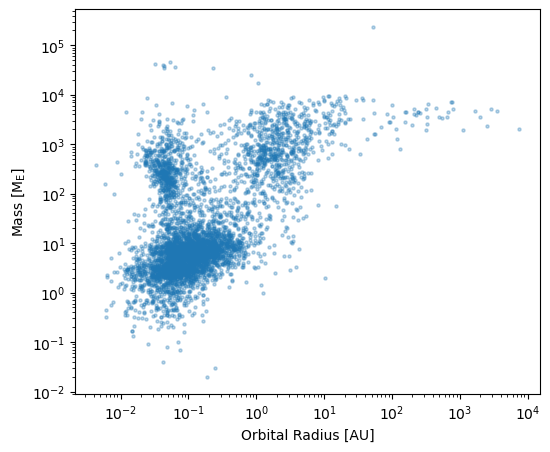

In [313]:
#mport matplotlib.pyplot as plt
df.plot(kind='scatter', x='orbital_radius_AU', y='mass_ME', #c='planet_type', 
        loglog=True, xlabel='Orbital Radius [AU]',# bins='log',
        ylabel='Mass [M$_\mathrm{E}$]', marker='.', #cmap='viridis' , 
        alpha=0.3, figsize=[6,5])
#c & cmap can be used with non-numeric data only if the column is Categorical

These methods can also be called on individual Groups with the `.get_group()` function, but you may need to use the kwarg `column` instead of x or y, depending on your choice of plot. 

For GroupBy objects, the only plot types implemented are `'hist'`, `'boxplot'`, and the ordinary `'line'` plot.

<Axes: xlabel='Radius [R$_\\mathrm{E}$]', ylabel='Frequency'>

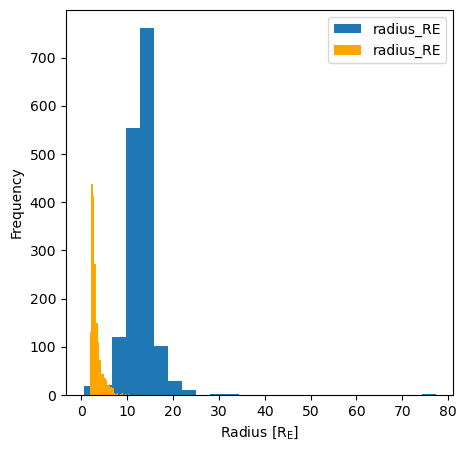

In [325]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
grouped1.get_group(('Gas Giant',)).plot(kind='hist', column='radius_RE', bins=25,
                                          xlabel='Radius [R$_\mathrm{E}$]', ax=ax,
                                          figsize=[5,5])
grouped1.get_group(('Neptune-like',)).plot(kind='hist', column='radius_RE', bins=25,
                                          xlabel='Radius [R$_\mathrm{E}$]', ax=ax,
                                          figsize=[5,5], color='orange')

There are a few other types of plotting functions available in `pandas.plotting`, which may be useful as preliminary visual statistical assessments to inform further analyses, but I won't go into in much detail because they are fairly niche.
- `scatter_matrix()`, `andrews_curves()`, `& parallel_coordinates()` are all useful for seeing if variables are correlated, especially `scatter_matrix()`, but the `Seaborn` plotting package has better utilities for the same purpose as `scatter_matrix()` and the results of the other 2 functions are generally hard to interpret and relatively low information for the effort. 
- `autocorrelation_plot()` & `lag_plot()` are good to check if your (time) Series data are random or not. The former is more informative as it will also show the lag times that produce non-zero autocorrelations. 
- `bootstrap_plot()` takes a Series and visualizes the uncertainty of the mean, media, & midrange statistics
- `radviz()` is kind of like a hybrid of web diagram & k-means clustering scatter plot. I'll let [the API page](https://pandas.pydata.org/docs/reference/api/pandas.plotting.radviz.html) explain a little more about what it's doing.

(0.001, 10000)

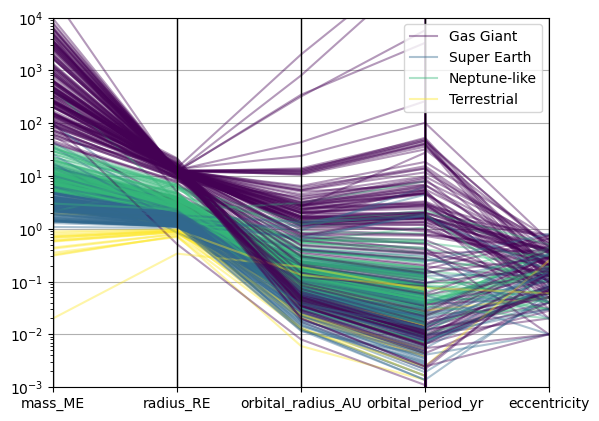

In [138]:
from pandas.plotting import parallel_coordinates as pcs
import matplotlib.pyplot as plt
pcs(df[['planet_type',*df.columns[4:9]]].iloc[::10],'planet_type',colormap='viridis',alpha=0.4)
plt.yscale('log')
plt.ylim(10**-3,10**4)

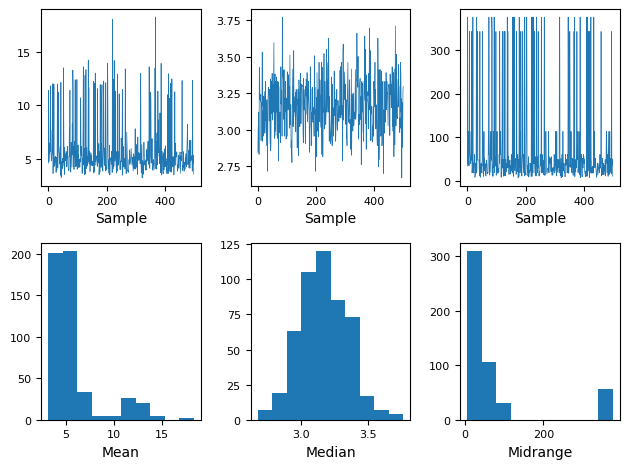

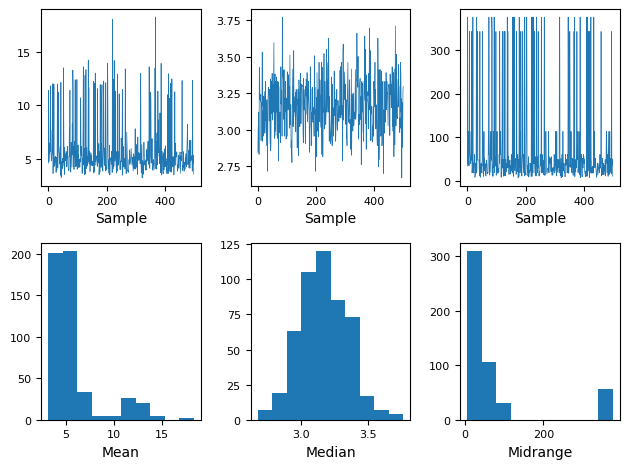

In [155]:
from pandas.plotting import bootstrap_plot as bsp
#size = # of data points per sample (default = 50)
#samples = # of times to rerun the bootstrap sampling (default = 500)
bsp(df.groupby('planet_type').get_group('Super Earth')['mass_ME'],
               samples=500, size=100, linewidth=0.5)

If you're interested in plotting the contents of DataFrames more professionally, I highly recommend you give the [Seaborn module](https://seaborn.pydata.org/) a look, as it provides many more options with much more polish.

## Time Series
Pandas was designed for financial panel data, which is fundamentally a kind of time series, so Pandas has a well-developed suite of time series functions. These functions are optimally suited for time increments from nanoseconds to weeks; if your smallest time step is larger than a week, you can certainly degrade the native time resolution to span a larger time duration, but the lengths you must go to keep the resolution coarse and adapt other functions to it are such that I would not recommend going through the trouble.  

#### Defining, parsing, & creating the main data types
Pandas incorporates NumPy `datetime64` & `timedelta64` data types, plus object classes from the `datetime` module & its `dateutil` extension, to define 3 Pandas data types & 1 scalar class:
1. `datetime64[ns(,tz)]`: datatype of a Series of Timestamp-type (NumPy datetime64) scalars, which may be just dates, just times, or most often some combination of the two. The default units are ns, and a timezone (tz) can optionally be specified. Coerced to `DatetimeIndex` if used as an Index for a Series or DataFrame.
2. `timedelta64[ns]`: datatype of a Series of Timedelta-type (NumPy timedelta64) scalars, associated with a unit that defaults to ns, representing absolute time increments from some user-defined start time. Coerced to `TimedeltaIndex` if used as an Index for a Series or DataFrame. Each index may be treated either as points or bin edges.
3. `period[freq]`: like `datetime64`, but lets one specify a start date and a recurrence rate. These are typically treated like bins that data falls *between*, not instantaneous points in time at which data is measured. Coerced to `PeriodIndex` if set as the Index for a Series or DataFrame. 

- `DateOffset`: not its own Pandas data type, but imported implicitly from `dateutil` to combine `timedelta`-like functionality with calendar rule (e.g. to handle leap years or daylight savings time). I won't go into these much in the interest of time and because these are fairly niche; [the documentation for this is pretty good](https://pandas.pydata.org/docs/user_guide/timeseries.html#dateoffset-objects).

Most of the time your job will involve parsing dates and times from other sources rather than generating them from scratch, so Pandas includes a few relevant conversion functions:

- `pd.to_datetime(*arg, fmt=None, **kwargs)`: This function accepts strings, arrays, Series, or DataFrames and either attempts to format the data based on a format string passed to `fmt` or tries to infer the typical format with or without the aid of extra kwargs. If the data are associated with time zones and you set the `utc` kwarg to `True`, the data will be automatically converted to UTC. Please see the official documentation for the full list of kwargs, as it is extensive.
- `pd.to_timedelta(*arg, unit=None)`: This function accepts strings, arrays, or Series and tries to convert them to time increments based on either the `unit` kwarg or acceptable unit characters that are part of the data in the argument. Please see the official documentation for the full list of acceptable units; as any time units from months to nanseconds are allowed, most have more than one possible format, and several of the most common abbreviations are *disallowed* due to ambiguity. Unfortunately, units of months or larger are entirely disallowed. In those cases, you will need to do additional reformatting.

It's a good idea to spend some time digesting the [summary table on time series data types and methods of definition in the Pandas documentation](https://pandas.pydata.org/docs/user_guide/timeseries.html#overview). Still, it can be hard to wrap your head around the meanings of and differences between each time series data type without seeing them in use, so let's dive in.

In [67]:
#from datetime import datetime as dttm
sunrises= ['2023-12-01 08:11:00',
           '2023-12-11 08:25:00',
           '2023-12-21 08:34:00',
           '2023-12-31 08:36:00',
           '2024-01-10 08:32:00',
           '2024-01-20 08:21:00']
daylens = [7.47583, 7.14306, 7.01583,
           7.11306, 7.42167, 7.90278]
srt = pd.to_datetime(sunrises,
                     format="%Y-%m-%d %H:%M:%S")
print(srt, '\n')
ts = pd.Series(daylens,index=srt)
print(ts)

DatetimeIndex(['2023-12-01 08:11:00', '2023-12-11 08:25:00',
               '2023-12-21 08:34:00', '2023-12-31 08:36:00',
               '2024-01-10 08:32:00', '2024-01-20 08:21:00'],
              dtype='datetime64[ns]', freq=None) 

2023-12-01 08:11:00    7.47583
2023-12-11 08:25:00    7.14306
2023-12-21 08:34:00    7.01583
2023-12-31 08:36:00    7.11306
2024-01-10 08:32:00    7.42167
2024-01-20 08:21:00    7.90278
dtype: float64


<Axes: >

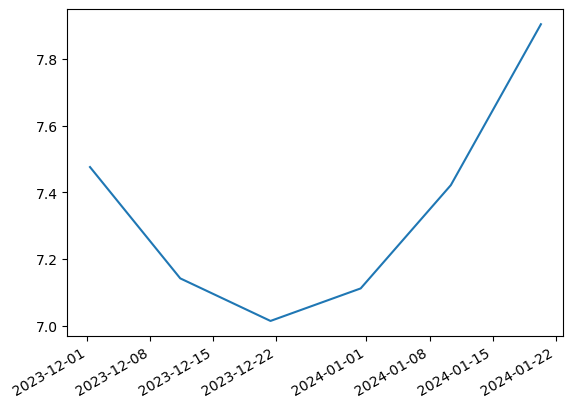

In [73]:
import matplotlib.pyplot as plt
ts.rename('day_len_hr').plot()

In [112]:
print(pd.to_timedelta(1.5578065*np.arange(10), unit='ms'))

TimedeltaIndex([          '0 days 00:00:00', '0 days 00:00:00.001557807',
                '0 days 00:00:00.003115613', '0 days 00:00:00.004673420',
                '0 days 00:00:00.006231226', '0 days 00:00:00.007789033',
                '0 days 00:00:00.009346839', '0 days 00:00:00.010904646',
                '0 days 00:00:00.012462452', '0 days 00:00:00.014020259'],
               dtype='timedelta64[ns]', freq=None)


If you do have to create datetime, timedelta, or period-type objects from scratch, there are also a few convenience functions, all of which can be labelled (for use as a Series or DataFrame column) with a `name` kwarg:

1. `pd.date_range(start, end=None, periods=None, freq=None)`: creates a `DatetimeIndex` array; two of the three kwargs after `start` must be specified. The `periods` kwarg has a different meaning depending on whether the other kwarg specified is `end` or `freq`. If you specify `freq` with `periods`, then `freq` gives the time increment to step forward from `start` and `periods` specifies the number of steps to take. If you specify `end` with `periods`, then `periods` is the number of equal-duration steps to divide the range \[`start`,`end`\] into, endpoint inclusive.
2. `pd.timedelta_range(start=None, end=None, periods=None, freq=None)`: creates a `TimedeltaIndex` array; exactly 3 of the 4 kwargs I have shown must be specified, but you can combine any 3 to different effect.
3. `pd.period_range(start=None, end=None, periods=None, freq=None)`: creates a `PeriodIndex` array; must specify exactly 2 of the `start`, `end`, and `periods` kwargs. If `start` and `end` are specified but not `periods` or `freq`, then `freq` defaults to days, even if `end` is less than 1 day after `start`.

In [139]:
print(pd.date_range('2020-03-05',end='2021-12-25',periods=15))

DatetimeIndex([          '2020-03-05 00:00:00',
               '2020-04-21 03:25:42.857142857',
               '2020-06-07 06:51:25.714285714',
               '2020-07-24 10:17:08.571428572',
               '2020-09-09 13:42:51.428571428',
               '2020-10-26 17:08:34.285714284',
               '2020-12-12 20:34:17.142857144',
                         '2021-01-29 00:00:00',
               '2021-03-17 03:25:42.857142856',
               '2021-05-03 06:51:25.714285712',
               '2021-06-19 10:17:08.571428568',
               '2021-08-05 13:42:51.428571424',
               '2021-09-21 17:08:34.285714288',
               '2021-11-07 20:34:17.142857144',
                         '2021-12-25 00:00:00'],
              dtype='datetime64[ns]', freq=None)


In [37]:
print(pd.date_range('2020-03-05 06:00:00',end='2020-03-05 18:00:00'))

DatetimeIndex(['2020-03-05 06:00:00'], dtype='datetime64[ns]', freq='D')


In [55]:
print(pd.timedelta_range(start='1 day', freq='90min', periods=24)) #can't use 1:30 or 1h30m

TimedeltaIndex(['1 days 00:00:00', '1 days 01:30:00', '1 days 03:00:00',
                '1 days 04:30:00', '1 days 06:00:00', '1 days 07:30:00',
                '1 days 09:00:00', '1 days 10:30:00', '1 days 12:00:00',
                '1 days 13:30:00', '1 days 15:00:00', '1 days 16:30:00',
                '1 days 18:00:00', '1 days 19:30:00', '1 days 21:00:00',
                '1 days 22:30:00', '2 days 00:00:00', '2 days 01:30:00',
                '2 days 03:00:00', '2 days 04:30:00', '2 days 06:00:00',
                '2 days 07:30:00', '2 days 09:00:00', '2 days 10:30:00'],
               dtype='timedelta64[ns]', freq='90T')


In [17]:
pd.Series(pd.timedelta_range(start='1 day 12:15:00', end='3 days 21:45:00', periods=16))

0    1 days 12:15:00
1    1 days 16:05:00
2    1 days 19:55:00
3    1 days 23:45:00
4    2 days 03:35:00
5    2 days 07:25:00
6    2 days 11:15:00
7    2 days 15:05:00
8    2 days 18:55:00
9    2 days 22:45:00
10   3 days 02:35:00
11   3 days 06:25:00
12   3 days 10:15:00
13   3 days 14:05:00
14   3 days 17:55:00
15   3 days 21:45:00
dtype: timedelta64[ns]

#### Timestamp formatting and precision limits
Arguments of `date_range()` and `period_range()` where timestamp strings are expected will also take integers and floats. Even a plain year passed as a *string* will be interpreted as a timestamp, specifically midnight January 1 of that year. *Integers or floats,* however, will be interpreted as nanoseconds (default), or the units specified by `unit`, *from midnight on January 1, 1970*. **Time since 1970-01-01 is called Unix time, and it is typically expressed as an integer or float with units of seconds (traditional), microseconds, or nanoseconds (pandas default)**. Since Julian Dates are also expressed as floats, this means you will have to pass any Julian Dates, which must be in units of days, through `pd.to_datetime(<date>, unit='D', origin='julian')` before working with them. 

In [160]:
print(pd.Timestamp.min, '=', pd.Timestamp.min.value,
      'ns in Unix time, or\n', bin(pd.Timestamp.min.value), 'in binary.\n')
print(pd.Timestamp.max, '=', pd.Timestamp.max.value,
      'ns in Unix time, or\n', bin(pd.Timestamp.max.value), 'in binary.')

1677-09-21 00:12:43.145224193 = -9223372036854775807 ns in Unix time, or
 -0b111111111111111111111111111111111111111111111111111111111111111 in binary.

2262-04-11 23:47:16.854775807 = 9223372036854775807 ns in Unix time, or
 0b111111111111111111111111111111111111111111111111111111111111111 in binary.


Unfortunately, dates can only be represented in Unix time in ns on a 64-bit system between about 1677 and 2262. In other words, if you have to parse dates outside that range but later than 0 CE(/AD), you will have to define the out-of-bounds date with a larger unit (e.g. `'s'`) using `pd.Timestamp(<date>, unit=<unit>)`. **For BC(E) dates, only `np.datetime64()` can parse them as Unix time correctly and in a format that `pd.Timestamp()` can then use.** Be careful to check what units the results are in and make sure the same units are supplied to the `unit` kwarg of `pd.Timestamp()`. If you have an array of out-of-bounds times, `pd.to_datetime()` typically won't be able to handle it regardless of unit, so you would have to apply a user-defined function with at least a couple of conversions through `np.datetime64()` and Unix time, **and** change the unit precision to get workable datetimes. **My advice: if you have to work with years BCE and/or your precision is no better than years, Pandas Time Series functionality probably isn't worth the effort to make it work.**

In [213]:
print(pd.Timestamp('476-09-04T12:00:00')) #fall of Rome
print(pd.Timestamp(-90000000000, unit='s')) # 882 BCE

0476-09-04 12:00:00
-882-01-06 08:00:00


In [257]:
l=['-00{}-03-21'.format(n) for n in range(1,6)[::-1]]+['{}-03-21'.format(str(n).zfill(4)) for n in range(13)]
print(np.datetime64(l[0]).dtype)
print(pd.Series(l).apply(lambda x: pd.Timestamp(np.datetime64(x).astype(int), unit='D')))    

datetime64[D]
0     -005-03-21 00:00:00
1     -004-03-21 00:00:00
2     -003-03-21 00:00:00
3     -002-03-21 00:00:00
4     -001-03-21 00:00:00
5     0000-03-21 00:00:00
6     0001-03-21 00:00:00
7     0002-03-21 00:00:00
8     0003-03-21 00:00:00
9     0004-03-21 00:00:00
10    0005-03-21 00:00:00
11    0006-03-21 00:00:00
12    0007-03-21 00:00:00
13    0008-03-21 00:00:00
14    0009-03-21 00:00:00
15    0010-03-21 00:00:00
16    0011-03-21 00:00:00
17    0012-03-21 00:00:00
dtype: object


Another note about `pd.date_range()`: if you specify `freq='M'`, and your start date is not the beginning of the month, regardless of the input start or end dates, the output start and end dates will be the last day of each month. If you instead specify 12 periods, the year will be subdivided into 12 down to nanosecond precision. If you want a precision of days and recurrence on a particular date of each month, you'll have to create the dates as strings first.

#### Setting, getting, and shifting times and timezones
Time Series have an accessor attribute, `.dt`, that allows you to extract any of the components (year, month, day, hour, min, second, etc) of the datetimes in your Series. If your Series is timedelta-type, you can extract all of the components at once to a dataframe (datetimes don't have this feature yet, but there is a PR in the works for it). Note that this accessor applieds only to Series, not Indexes.

In [2]:
mm = pd.Series(pd.date_range('2024-03-19T12:15:00', end='2024-03-31T21:20', freq='3h45min'))

In [321]:
mm.dt.day

0     19
1     19
2     19
3     19
4     20
      ..
75    31
76    31
77    31
78    31
79    31
Length: 80, dtype: int32

In [324]:
mm[mm.dt.day==29]

61   2024-03-29 01:00:00
62   2024-03-29 04:45:00
63   2024-03-29 08:30:00
64   2024-03-29 12:15:00
65   2024-03-29 16:00:00
66   2024-03-29 19:45:00
67   2024-03-29 23:30:00
dtype: datetime64[ns]

In [229]:
tt = pd.Series(pd.timedelta_range(start='1 day 12:15:00', end='3 day 21:45:00', periods=35))
tt.dt.components.head(2) #also for datetimes since a few months ago

,days,hours,minutes,seconds,milliseconds,microseconds,nanoseconds
0,1,12,15,0,0,0,0
1,1,13,56,28,235,294,117


**Shifting.** If you have a DatetimeIndex or PeriodIndex, it is very easy to shift the values by a certain amount of time, or, for example duplicate a span of time indexes to other dates. Indeed, you don't even have to extract the Index from a Series or DataFrame: as long as the index of a Series or DataFrame is a timestamp, period, or timedelta, `.shift()` works on the indexes of those directly. The method for this is `.shift(periods=1, freq=None)`. This moves a Datetime- or PeriodIndex forward or backward by a number of increments specified by `periods` with a size specified by `freq`. If `freq` is left as None, it is taken from the smallest increment between timesteps, and `periods` defaults to 1 unit of these increments.

In [8]:
day1i = pd.date_range('2024-02-05T20:00:00', end='2024-02-05T23:30:00', freq='15min')
#day1i.shift(periods=2,freq='1D')
day1i.append([day1i.shift(freq='{}D'.format(str(i))) for i in range(1,3)])

DatetimeIndex(['2024-02-05 20:00:00', '2024-02-05 20:15:00',
               '2024-02-05 20:30:00', '2024-02-05 20:45:00',
               '2024-02-05 21:00:00', '2024-02-05 21:15:00',
               '2024-02-05 21:30:00', '2024-02-05 21:45:00',
               '2024-02-05 22:00:00', '2024-02-05 22:15:00',
               '2024-02-05 22:30:00', '2024-02-05 22:45:00',
               '2024-02-05 23:00:00', '2024-02-05 23:15:00',
               '2024-02-05 23:30:00', '2024-02-06 20:00:00',
               '2024-02-06 20:15:00', '2024-02-06 20:30:00',
               '2024-02-06 20:45:00', '2024-02-06 21:00:00',
               '2024-02-06 21:15:00', '2024-02-06 21:30:00',
               '2024-02-06 21:45:00', '2024-02-06 22:00:00',
               '2024-02-06 22:15:00', '2024-02-06 22:30:00',
               '2024-02-06 22:45:00', '2024-02-06 23:00:00',
               '2024-02-06 23:15:00', '2024-02-06 23:30:00',
               '2024-02-07 20:00:00', '2024-02-07 20:15:00',
               '2024-02-

If applied to an existing data structure (Series or DataFrame) with a temporal index, it will essentially reindex the structure, keeping the data in order but assigning them all new timestamps shifted by the specified amount. Avoid the `.shift()` function if it's important to you that the data do not move with respect to their associated times. Also be aware that some choices of shift increments may introduce NaNs and cause data to be dropped from beginning or end of a dataset. This is more likely when `shift()` is applied to a DataFrame with different shifts for each column, or if no kwargs are specified and the minimum shift unit (nanoseconds) is used.

In [28]:
tdum = pd.Series(np.random.randint(100, size=len(day1i)),index=day1i)
tdum.shift()

2024-02-05 20:00:00     NaN
2024-02-05 20:15:00    24.0
2024-02-05 20:30:00     1.0
2024-02-05 20:45:00    47.0
2024-02-05 21:00:00    76.0
2024-02-05 21:15:00    99.0
2024-02-05 21:30:00    58.0
2024-02-05 21:45:00     6.0
2024-02-05 22:00:00    61.0
2024-02-05 22:15:00    18.0
2024-02-05 22:30:00    72.0
2024-02-05 22:45:00     4.0
2024-02-05 23:00:00    10.0
2024-02-05 23:15:00    69.0
2024-02-05 23:30:00     7.0
Freq: 15min, dtype: float64

In [40]:
tdum.shift(periods=-3,freq="D")

2024-02-02 20:00:00    24
2024-02-02 20:15:00     1
2024-02-02 20:30:00    47
2024-02-02 20:45:00    76
2024-02-02 21:00:00    99
2024-02-02 21:15:00    58
2024-02-02 21:30:00     6
2024-02-02 21:45:00    61
2024-02-02 22:00:00    18
2024-02-02 22:15:00    72
2024-02-02 22:30:00     4
2024-02-02 22:45:00    10
2024-02-02 23:00:00    69
2024-02-02 23:15:00     7
2024-02-02 23:30:00    36
Freq: 15min, dtype: int64

There are 2 important time series methods you need to know if you plan to include time zones:

1. `.tz_localize(<TZ>)`: append this to a datetime, DatetimeIndex, PeriodIndex, Series, or DataFrame of datetimes to either **a)** specify a time zone when one is *not* already present, or **b)** if `None` is passed instead of a time zone string, remove all time zone information.
2. `.tz_convert(<TZ>)`: append this to a datetime, DatetimeIndex, PeriodIndex, Series, or DataFrame of datetimes to either **a)** convert to the specified time zone, or **b)** if `None` is passed instead of a time zone string, convert to UTC and then remove all time zone information.

In [263]:
dts = pd.date_range('2020-03-05T17:00:00',end='2021-12-25T17:00:00',
              periods=9).tz_localize('CET')
print(dts)
print(dts.tz_convert('EST'))

DatetimeIndex(['2020-03-05 17:00:00+01:00', '2020-05-27 05:00:00+02:00',
               '2020-08-17 17:00:00+02:00', '2020-11-08 05:00:00+01:00',
               '2021-01-29 17:00:00+01:00', '2021-04-22 05:00:00+02:00',
               '2021-07-13 17:00:00+02:00', '2021-10-04 05:00:00+02:00',
               '2021-12-25 17:00:00+01:00'],
              dtype='datetime64[ns, CET]', freq=None)
DatetimeIndex(['2020-03-05 11:00:00-05:00', '2020-05-26 22:00:00-05:00',
               '2020-08-17 10:00:00-05:00', '2020-11-07 23:00:00-05:00',
               '2021-01-29 11:00:00-05:00', '2021-04-21 22:00:00-05:00',
               '2021-07-13 10:00:00-05:00', '2021-10-03 22:00:00-05:00',
               '2021-12-25 11:00:00-05:00'],
              dtype='datetime64[ns, EST]', freq=None)


#### Resampling
Time Series in Pandas inherently come with methods to resample data to the desired temporal indexing scheme.

**Resampling** means taking data from one time series and interpolating to other time steps within the same bounds, whether those time steps are more closely spaced than the original (*upsampling*), more widely spaced (*downsampling*), or merely shifted.

To shift or downsample, just call the method `.resample('<unit>')` on your time Series (or DataFrame, as long as indexes are timestamps). **`.resample()` is fundamentally a time-based GroupBy.** That means any built-in method you can call on a GroupBy method can be called on the output of `.resample()`.

To upsample, `.resample()` is not enough by itself: you must choose a fill/interpolation method. The most basic method is to use `.resample('<unit>').asfreq()`, but if the chosen upsampled unit does not evenly divide into or align with the original unit, most of the resampled points will be `NaN`. There is also the forward-fill method, `.resample('<unit>').ffill(limit=limit)`, where every data point is propagated forward to intervening sample points either up to the number of points specified by the `limit` kwarg or until the next point in the original series is reached. However, I am willing to bet most of you will want or need genuine interpolation that attempts to match the progression of the original data. For that you have `.resample('<unit>').interpolate(method='linear')`, in which the `method` can be any method string accepted by either `scipy.interpolate.interp1d` or `scipy.interpolate.UnivariateSpline`, plus several others. 

Let's say you have data collected every month for a year. That would give you 12 data points. If you wanted weekly data (roughly 52 data points) and the data are well-behaved, you could upsample from a monthly frequency to a weekly frequency. Here, I'll do an example using the average monthly high temperatures for my hometown, and since these data are from 2021, I'll pretend these are data collected on the 15th of every month of 2021. This turns out to be really bad for interpolation since the time increments are not constant.

In [77]:
ts = pd.Series([18.,20.,24.,27.,30.,32.,33.,33.,31.,27.,23.,20.],
               index=[pd.to_datetime('2021-{}-15'.format(str(i).zfill(2)))
                                     for i in range(1,13)])

In [42]:
print(ts)

2021-01-15    18.0
2021-02-15    20.0
2021-03-15    24.0
2021-04-15    27.0
2021-05-15    30.0
2021-06-15    32.0
2021-07-15    33.0
2021-08-15    33.0
2021-09-15    31.0
2021-10-15    27.0
2021-11-15    23.0
2021-12-15    20.0
dtype: float64


In [50]:
print(ts.resample('1D').asfreq()[0:40])

2021-01-15    18.0
2021-01-16     NaN
2021-01-17     NaN
2021-01-18     NaN
2021-01-19     NaN
2021-01-20     NaN
2021-01-21     NaN
2021-01-22     NaN
2021-01-23     NaN
2021-01-24     NaN
2021-01-25     NaN
2021-01-26     NaN
2021-01-27     NaN
2021-01-28     NaN
2021-01-29     NaN
2021-01-30     NaN
2021-01-31     NaN
2021-02-01     NaN
2021-02-02     NaN
2021-02-03     NaN
2021-02-04     NaN
2021-02-05     NaN
2021-02-06     NaN
2021-02-07     NaN
2021-02-08     NaN
2021-02-09     NaN
2021-02-10     NaN
2021-02-11     NaN
2021-02-12     NaN
2021-02-13     NaN
2021-02-14     NaN
2021-02-15    20.0
2021-02-16     NaN
2021-02-17     NaN
2021-02-18     NaN
2021-02-19     NaN
2021-02-20     NaN
2021-02-21     NaN
2021-02-22     NaN
2021-02-23     NaN
Freq: D, dtype: float64


In [44]:
print(ts.resample('W').interpolate())

2021-01-17     NaN
2021-01-24     NaN
2021-01-31     NaN
2021-02-07     NaN
2021-02-14     NaN
2021-02-21     NaN
2021-02-28     NaN
2021-03-07     NaN
2021-03-14     NaN
2021-03-21     NaN
2021-03-28     NaN
2021-04-04     NaN
2021-04-11     NaN
2021-04-18     NaN
2021-04-25     NaN
2021-05-02     NaN
2021-05-09     NaN
2021-05-16     NaN
2021-05-23     NaN
2021-05-30     NaN
2021-06-06     NaN
2021-06-13     NaN
2021-06-20     NaN
2021-06-27     NaN
2021-07-04     NaN
2021-07-11     NaN
2021-07-18     NaN
2021-07-25     NaN
2021-08-01     NaN
2021-08-08     NaN
2021-08-15    33.0
2021-08-22    33.0
2021-08-29    33.0
2021-09-05    33.0
2021-09-12    33.0
2021-09-19    33.0
2021-09-26    33.0
2021-10-03    33.0
2021-10-10    33.0
2021-10-17    33.0
2021-10-24    33.0
2021-10-31    33.0
2021-11-07    33.0
2021-11-14    33.0
2021-11-21    33.0
2021-11-28    33.0
2021-12-05    33.0
2021-12-12    33.0
2021-12-19    33.0
Freq: W-SUN, dtype: float64


Naively you would think `.interpolate()` would be able to make a decent sinusoid out of this after upsampling to weeks, even with just linear interpolation. And it would if every 4th week started on the 15th. Unfortunately, for most of the year, the existing data will not align with the interpolated times; the only overlapping date is 15-Aug.

The proper way to fix this would be to convert to day numbers and interpolate with SciPy or Numpy or `df.interpolate()` removed from its time series context. However, if the precision of your upsampled data is low enough for that not to matter, you could instead use the original data to forward fill the next available date in the upsampled time series, and *then* interpolate, like so:

In [45]:
tsr = ts.resample('W').ffill(limit=1).interpolate()
print(tsr)

2021-01-17    18.00
2021-01-24    18.40
2021-01-31    18.80
2021-02-07    19.20
2021-02-14    19.60
2021-02-21    20.00
2021-02-28    21.00
2021-03-07    22.00
2021-03-14    23.00
2021-03-21    24.00
2021-03-28    24.75
2021-04-04    25.50
2021-04-11    26.25
2021-04-18    27.00
2021-04-25    27.75
2021-05-02    28.50
2021-05-09    29.25
2021-05-16    30.00
2021-05-23    30.40
2021-05-30    30.80
2021-06-06    31.20
2021-06-13    31.60
2021-06-20    32.00
2021-06-27    32.25
2021-07-04    32.50
2021-07-11    32.75
2021-07-18    33.00
2021-07-25    33.00
2021-08-01    33.00
2021-08-08    33.00
2021-08-15    33.00
2021-08-22    33.00
2021-08-29    32.50
2021-09-05    32.00
2021-09-12    31.50
2021-09-19    31.00
2021-09-26    30.00
2021-10-03    29.00
2021-10-10    28.00
2021-10-17    27.00
2021-10-24    26.20
2021-10-31    25.40
2021-11-07    24.60
2021-11-14    23.80
2021-11-21    23.00
2021-11-28    22.25
2021-12-05    21.50
2021-12-12    20.75
2021-12-19    20.00
Freq: W-SUN, dtype: 

<Axes: >

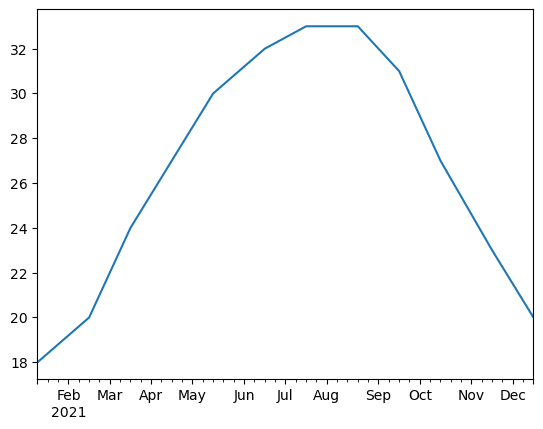

In [49]:
import matplotlib.pyplot as plt
tsr.plot()

**Be aware that upsampling, like interpolation in general, is usually only meaningful when the original data are smooth and well-sampled.** If the data are stochastic, discontinuous, or excessively noisy, it will be garbage in, garbage out. Data following a well-defined curve may yield decent results even if sparsely sampled, but if the sparse data are clumpy, it's most efficient to avoid upsampling where naive methods would yield long stretches of NaNs.

I've tried several other methods to find something more intuitive than the [cookbook method in the documentation](https://pandas.pydata.org/docs/user_guide/timeseries.html#sparse-resampling), but the latter is the only one that seems to work for efficient upsampling. It skips the `.resample()` wrapper and uses the underlying `.groupby()` method directly, at the cost of being able to use some methods that only `.resample()` has among the two, like `.interpolate()`. It also heavily relies on the conversion of `Timestamps` and `Timedeltas` to Unix epochs in nanoseconds for appropriate rounding.

To demonstrate in another vaguely realistic example: since the night sky is only visible at, well, night, it's easy to have only partial light curves for variable objects observed from the ground that have periods of a couple days or less (similarly, large fractions of the sky are only visible for a little over half the year, which causes the same issue for variable objects with periods of months to a couple years). So let's say that you got to observe a variable star with a 5-hour pulsation period for 5 weeknights between the hours 20:00 and 23:30, and in those 3-hour blocks, you took data every 15 minutes. Your data might look like this:

In [78]:
day1i = pd.date_range('2024-02-05T20:00:00', end='2024-02-05T23:30:00', freq='15min')

In [79]:
inds = day1i.append([day1i.shift(freq='{}D'.format(str(i))) for i in range(1,5)])

In [80]:
l = [np.linspace(4.88, 4.7, 15),
     np.hstack((np.linspace(4.82, 4.69,7), np.array(4.68),
                           np.linspace(4.68, 4.83,7))),
     np.linspace(4.66, 4.87, 15),
     np.hstack((np.linspace(4.77, 4.89,7), np.array(4.89),
                           np.linspace(4.88, 4.76,7))),
     np.linspace(4.87, 4.69, 15)]
#data loosely based on Delta Scuti

In [81]:
fudge=pd.Series(np.concatenate(l),index = inds)

In [82]:
from functools import partial
from pandas.tseries.frequencies import to_offset

def round(t, freq):
    freq = to_offset(freq)
    td = pd.Timedelta(freq)
    return pd.Timestamp((t.value // td.value) * td.value)
# What the .value attributes do above:
### Timestamp.value = nanoseconds past 01-01-1970 (Unix epoch)
### Timedelta.value = time offset in nanoseconds 

fudge.groupby(partial(round, freq="2min")).mean()

2024-02-05 20:00:00    4.880000
2024-02-05 20:14:00    4.867143
2024-02-05 20:30:00    4.854286
2024-02-05 20:44:00    4.841429
2024-02-05 21:00:00    4.828571
                         ...   
2024-02-09 22:30:00    4.741429
2024-02-09 22:44:00    4.728571
2024-02-09 23:00:00    4.715714
2024-02-09 23:14:00    4.702857
2024-02-09 23:30:00    4.690000
Length: 75, dtype: float64


As a final note, I want to mention a core function called `pd.Grouper()` (note the capitalization!) that can be passed to `df.groupby()` to provide additional instructions. With ordinary grouping on column or row names, it's not needed; for a DataFrame `df` to be grouped based on some column `colA`, `df.groupby(pd.Grouper(key="colA"))` is the same as `df.groupby('colA')`. However, to group by *datetimes or timedeltas in addition* to another key/column/other criterion, `pd.Grouper()` must be used. Essentially this is how you do GroupBy and resampling at the same time. It's a rather niche topic, so I will refer readers to [the official documents](https://pandas.pydata.org/docs/reference/api/pandas.Grouper.html#pandas-grouper) and some helpful extra detail on [stack overflow](https://stackoverflow.com/a/45156301/3934626).

## Advanced Topics
This section will mostly be a miscellaneous collection of features that I don't have the time to cover in much depth but nevertheless want you to be aware of.

### Preparing input for Machine Learning (ML)
ML programs like TensorFlow and PyTorch are highly compatible with Series/DataFrame inputs, but there are still limitations to the data types that will produce useful results. For example (and this doesn't make much sense given what we actually know about exoplanets, but) let's say you wanted to build a neural network model that predicts the planet type based on a subset of the physical and orbital parameters. The physical and orbital parameters of the existing data are numerical, but Planet Type is a categorical variable with 5 unique values.

What we would want to do, then, is turn each of those categories into boolean columns. The column corresponding to the category to which the planet was assigned is True (1), and the rest of the category columns in that row are False (0). There is a function to do this in Pandas: `pd.get_dummies(data, drop_first=False, dtype=bool)`. The dtype kwarg lets you choose whether to cast the dummies as bool (default, less memory), float (more memory usage), or int (same memory as float). It even has a kwarg `drop_first` which lets you get rid of one of the categories on the assumption that not fitting any of the remaining categories is perfectly correlated with fitting the dropped category. Leaving highly correlated parameters in your input data introduces degeneracies that make it unnecessarily hard to converge on a single model, so it behoves you to weed out any columns that are complementary or scalar functions of other columns.

In [263]:
dummies = pd.get_dummies(df, columns=['planet_type'])#, dtype=int)
print(dummies[[c for c in dummies.columns.values if 'planet_type' in c]].head())
#dummies.drop('planet_type_Unknown', axis='columns').head()

                      planet_type_Gas Giant  planet_type_Neptune-like  \
#name                                                                   
11 Comae Berenices b                   True                     False   
11 Ursae Minoris b                     True                     False   
14 Andromedae b                        True                     False   
14 Herculis b                          True                     False   
16 Cygni B b                           True                     False   

                      planet_type_Super Earth  planet_type_Terrestrial  \
#name                                                                    
11 Comae Berenices b                    False                    False   
11 Ursae Minoris b                      False                    False   
14 Andromedae b                         False                    False   
14 Herculis b                           False                    False   
16 Cygni B b                            Fals

My one quibble with this is that you don't get to choose which category is dropped: it's always the first one (even though in this case we'd really prefer the last one, Unknown, to be dropped). But there's an easy enough workaround: leave `drop_first=False` and then call `.drop('col_to_drop', axis='columns', inplace=True)` on the result where `'col_to_drop'` is the column of data that you want to get rid of.

The reverse operation is also available if your dummy column names are well formulated and you want to compactify a bunch of dummy columns back into a single categorical column: `pd.from_dummies(data, sep=None)`. However, unless the categories are consistently only one or two characters, you'll likely be *increasing* rather than decreasing memory usage. Observe:

In [293]:
print(dummies[[c for c in dummies.columns.values if 'planet_type' in c]].memory_usage(deep=True).sum())

385752


In [294]:
print(df['planet_type'].memory_usage(deep=True))

847183


The 5 dummy columns put together are still less than half as memory intensive as the one original string-type data column!

There is another, more compact way to get a similar improvement in memory usage, however, if you have data where the number of unique values is much smaller than the total number of data points.

### The Categorical datatype
The Categorical datatype, **although it cannot be used as ML input,** essentially gives you the memory benefits of the dummy columns while retaining the visual intuitiveness of the original string format in print statements. Internally, it maps all the unique values of the column to short numerical codes in the column's place in memory, stores the codes in the smallest integer format that fits the largest-valued code, and only converts the codes to the associated strings when the data are printed. This way, it only has to store 1 copy of each unique value and the list of associated numeric codes. If your data have fewer than 8 categories, each code will be a single-digit 8-bit integer, which will be smaller in memory than even a typical floating point value by a factor of almost 8. Observe:

In [416]:
df.memory_usage(deep=True)

Index                359502
distance              42000
star_mag              42000
planet_type          355545
discovery_yr          42000
mass_ME               42000
radius_RE             42000
orbital_radius_AU     42000
orbital_period_yr     42000
eccentricity          42000
detection_method     348608
dtype: int64

In [199]:
df['planet_type']=df['planet_type'].astype('category')
df['detection_method']=df['detection_method'].astype('category')

In [418]:
df.memory_usage(deep=True)

Index                359502
distance              42000
star_mag              42000
planet_type            5757
discovery_yr          42000
mass_ME               42000
radius_RE             42000
orbital_radius_AU     42000
orbital_period_yr     42000
eccentricity          42000
detection_method       6383
dtype: int64

As you can see, the estimated size in memory of these new categorical columns dropped from 6 digits to 4; the categorical columns have been reduced to less than **2%** of their original size! For more typical DataFrames of 10-100x the size of this demo set, the savings would be even larger. Even better, vectorized string functions will still work, although you still have to be sure that everything you want to be considered part of the same category is consistently labeled before doing the conversion. Categories can also be integers, but numeric functions will not work on them.

**Don't forget these memory savings only apply when the number of categories is *much* smaller than the length of the column.**

To get attributes or methods of Categorical data, you will need the `.cat` accessor followed by the attribute or method. For instance, if you want to get the category names back as an index object, use `.cat.categories` like so:

In [315]:
df['planet_type'].cat.categories

Index(['Gas Giant', 'Neptune-like', 'Super Earth', 'Terrestrial', 'Unknown'], dtype='object')

You can also get a copy of the categorical column where the values are the index locations of the labels returned by `.cat.categories`:

In [311]:
df['planet_type'].cat.codes

#name
11 Comae Berenices b    0
11 Ursae Minoris b      0
14 Andromedae b         0
14 Herculis b           0
16 Cygni B b            0
                       ..
XO-7 b                  0
YSES 2 b                0
YZ Ceti b               3
YZ Ceti c               2
YZ Ceti d               2
Length: 5250, dtype: int8

Using the `.cat` accessor, Categories can be appended, removed, renamed, reordered (yes, you can assert an order!), and Categorical-type Series or Indexes can be initialized from scratch, as the following cells will demonstrate. If you remove an existing category label, rows where that label applied will then have a NaN in that column if printed normally, but the code will be -1. If you end up with a category label that isn't used (e.g. after deleting rows with bad data or binning data with gaps), `.unique()` will not return it, and it can be deleted easily with `.cat.remove_unused_categories()`.

In [458]:
junk = ['foo', 'bar', 'baz', 'baz', 'foo', 'bar', 'foo']
dumcat = pd.Series(junk, dtype='category')
dumcat.cat.categories

Index(['bar', 'baz', 'foo'], dtype='object')

In [459]:
rawcat = pd.Categorical(['foo', 'bar', 'baz', 'baz', 'foo', 'bar', 'foo'])
rawcat.categories

Index(['bar', 'baz', 'foo'], dtype='object')

You can assert order in your definition of categories so that you can sort the data by those categories even if the categories in question are non-numeric. Normally you would set `ordered=True` in the definition, but you can also do it later by calling `.cat.as_ordered()`, or get rid of it later with `.cat.as_unordered()`. Given a Series with ordered categories, calling .sort_values() will arrange the data in category order with any NaNs (places where data was not associated with any category) at the end.

In [460]:
rawcat = pd.Categorical(dumcat.values, categories=['foo','bar','qux'], ordered=True)
rawcat.categories

Index(['foo', 'bar', 'qux'], dtype='object')

In [461]:
pd.Series(rawcat).sort_values()

0    foo
4    foo
6    foo
1    bar
5    bar
2    NaN
3    NaN
dtype: category
Categories (3, object): ['foo' < 'bar' < 'qux']

In [453]:
dumcat = pd.Series(rawcat)
dumcat.unique()

['foo', 'bar', NaN]
Categories (3, object): ['foo' < 'bar' < 'qux']

In [454]:
dumcat = dumcat.cat.remove_unused_categories()
print(dumcat)

0    foo
1    bar
2    NaN
3    NaN
4    foo
5    bar
6    foo
dtype: category
Categories (2, object): ['foo' < 'bar']


In [455]:
dumcat=dumcat.cat.add_categories(['baz', 4])
dumcat[2:4]='baz'
dumcat

0    foo
1    bar
2    baz
3    baz
4    foo
5    bar
6    foo
dtype: category
Categories (4, object): ['foo' < 'bar' < 'baz' < 4]

If you add new categories to an existing Categorical object, those categories are, by default, added to the end. **If the Categorical was set as ordered, the new categories will be assumed to be larger than existing ones.**

In [456]:
dumcat.sort_values()

0    foo
4    foo
6    foo
1    bar
5    bar
2    baz
3    baz
dtype: category
Categories (4, object): ['foo' < 'bar' < 'baz' < 4]

If you don't like the new order, you can fix it with `.cat.reorder_categories([newcats], ordered=True)`.

In [457]:
dumcat=dumcat.cat.reorder_categories(dumcat.cat.categories[::-1], ordered=True)
dumcat.sort_values()

2    baz
3    baz
1    bar
5    bar
0    foo
4    foo
6    foo
dtype: category
Categories (4, object): [4 < 'baz' < 'bar' < 'foo']

Aside from efficient memory usage, Categories are mainly meant to be used as inputs to `.groupby()`, so they don't have that many methods or attributes, but what they have can be very handy. I highly recommend you [read the cookbook on Categoricals in the official pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html#categorical-data). If it's still not apparent why you might want to be able to group by categories whose labels are decoupled from the contents of the Series, the next section should make things clearer.

### Cutting (binning)

Let's say you have a numerical variable that you want to recast as categorical. This is a popular choice for, say, age or tax brackets. Pandas has 2 functions to let you do this, provided that you pass the data to bin as either a NumPy array or Series: 
- `pd.cut(data, bins, right=True, labels=None)`: here you can specify either n equal `bins` or array of variable bins, and optionally labels for each; `right=True` indicates bins include the right edges but not the left (`False` excludes both bin edges). 
- `pd.qcut(data, q)`: similar to `cut`, but specifically bins by *quantiles*, the number of which you specify using the 2nd positional argument (`q` in the documentation). Alternatively, you can manually specify quantiles by passing a list of decimal fractions (e.g. \[0.25, 0.5, 0.75, 1.0\] for qua**r**tiles).

Let's look at the planet radii column and see if there's a sensible way to cut the data:

<Axes: ylabel='Density'>

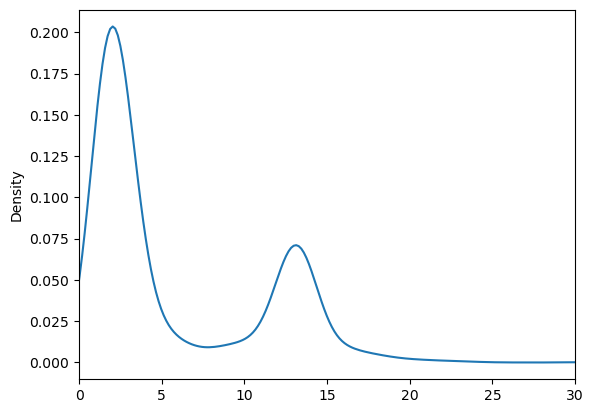

In [223]:
df['radius_RE'].plot(kind='kde', xlim=(0,30), xlabel='Radius')

That looks pretty bimodal. Let's cut it into 2 at about the 7-Earth-radius point : "Rocky" and "Gaseous". What you'll find is that depending on whether or not the `labels` kwarg is set, the return value is either a Categorical or an Interval object, respectively.

In [462]:
bcut = pd.cut(df['radius_RE'], bins=[df['radius_RE'].min(), 7, 
                                     df['radius_RE'].max()],
              labels=['Rocky', 'Gaseous'])

In [463]:
print(bcut)

#name
11 Comae Berenices b    Gaseous
11 Ursae Minoris b      Gaseous
14 Andromedae b         Gaseous
14 Herculis b           Gaseous
16 Cygni B b            Gaseous
                         ...   
XO-7 b                  Gaseous
YSES 2 b                Gaseous
YZ Ceti b                 Rocky
YZ Ceti c                 Rocky
YZ Ceti d                 Rocky
Name: radius_RE, Length: 5250, dtype: category
Categories (2, object): ['Rocky' < 'Gaseous']


In [243]:
print(pd.qcut(df['radius_RE'], q=4))

#name
11 Comae Berenices b    (11.715, 77.28]
11 Ursae Minoris b      (11.715, 77.28]
14 Andromedae b         (11.715, 77.28]
14 Herculis b           (11.715, 77.28]
16 Cygni B b            (11.715, 77.28]
                             ...       
XO-7 b                  (11.715, 77.28]
YSES 2 b                (11.715, 77.28]
YZ Ceti b                 (0.295, 1.76]
YZ Ceti c                 (0.295, 1.76]
YZ Ceti d                 (0.295, 1.76]
Name: radius_RE, Length: 5250, dtype: category
Categories (4, interval[float64, right]): [(0.295, 1.76] < (1.76, 2.733] < (2.733, 11.715] < (11.715, 77.28]]


Now let's see if we can group by these quantiles and compare to the `'planet_type'` groupby that we did when GroupBy objects were first introduced, which were grouped by putative planet type (which will be in reverse mass/size order relative to the Intervals above).

In [371]:
ivs = pd.qcut(df['radius_RE'], q=4,
              labels=['Terrestrial', 'Neptunian', 'Gaseous', 'Puffy'])
grouped4= df.groupby(ivs)
grouped4['mass_ME'].describe()

/tmp/ipykernel_39329/1694293747.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped4= df.groupby(ivs)


,count,mean,std,min,25%,50%,75%,max
radius_RE,,,,,,,,
Terrestrial,1315.0,3.770707,20.339182,0.02,1.55,2.42,3.1500,684.65
Neptunian,1309.0,10.702811,50.554692,1.90,4.82,5.90,7.1400,1303.80
Gaseous,1297.0,128.119854,969.751235,0.39,9.69,14.10,36.0000,25440.00
Puffy,1294.0,1701.556383,7358.263165,52.37,267.12,620.26,1707.3425,239136.00


In [372]:
grouped1['mass_ME'].describe()

,count,mean,std,min,25%,50%,75%,max
planet_type,,,,,,,,
Gas Giant,1612.0,1468.471433,6664.964763,38.14,190.720,467.27,1337.19,239136.00
Neptune-like,1825.0,15.289496,54.296279,2.00,6.390,8.30,12.30,1176.60
Super Earth,1595.0,5.775166,27.183984,0.60,2.300,3.15,4.27,750.48
Terrestrial,195.0,1.608564,11.395427,0.02,0.375,0.59,0.78,159.00
Unknown,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The results are the same shape.

### Sparse data
Another way to save on memory, if you have a DataFrame with lots of rows or columns that are mostly NaN, is to use the `SparseArray` format or `SparseDtype`. 
You can initialize Series or DataFrames as `SparseDtype` by setting the kwarg `dtype=SparseDtype(dtype=np.float64, fill_value=None)` in the `pd.Series()` or `pd.DataFrame()` initialization functions, or you can call the method `.astype(pd.SparseDtype("float", np.nan))` on an existing Series or DataFrame. There is also this function, `pd.arrays.SparseArray(data, **kwargs)`, that initializes a SparseArray given a dense array as data input, but this is rare.

Data of `SparseDtype` have a `.sparse` accessor in much the same way as datetime data have `.dt` and Categorical data have `.cat`, but the list of attributes and methods is very short:
- `df.sparse.density`: prints fraction of data that are non-NaN
- `df.sparse.fill_value`: prints fill value for NaNs, if any (might just return NaN)
- `df.sparse.from_spmatrix(data)`: makes a new `SparseDtype` DataFrame from a SciPy sparse matrix
- `df.sparse.to_coo()`: converts a DataFrame (or Series) to sparse SciPy COO type ([more on those here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_array.html#scipy.sparse.coo_array))


In [566]:
sdf = pd.DataFrame(np.random.randint(0,high=60,size=(6,6)), columns=['foo', 'bar', 'baz', 'qux', 'ham', 'pop'])
sdf[sdf<40]=np.NaN
sdf

,foo,bar,baz,qux,ham,pop
0,NaN,NaN,55.0,NaN,NaN,48.0
1,45.0,NaN,46.0,NaN,NaN,NaN
2,NaN,50.0,51.0,47.0,NaN,NaN
3,NaN,NaN,45.0,NaN,NaN,59.0
4,49.0,NaN,59.0,NaN,53.0,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN


In [567]:
sdf.memory_usage(deep=True)

Index    132
foo       48
bar       48
baz       48
qux       48
ham       48
pop       48
dtype: int64

In [569]:
sdf=sdf.astype(pd.SparseDtype("float", np.nan))
sdf.memory_usage(deep=True)

Index    132
foo       24
bar       12
baz       60
qux       12
ham       12
pop       24
dtype: int64

Since the data are random and I set 2/3 of the range of values to be NaN, if the sample is in fact random, `sdf.sparse.density` should print 1/3 as a decimal.

In [571]:
sdf.sparse.density

0.3333333333333334

A SparseArray is stored in 1D with all NaN values and their Indexes removed. DataFrames & Series with `SparseDtype` are somewhat more complex, but essentially the data & column/row labels are stored separately and the SparseDtype property only stores the locations of non-NaN values and a scalar fill value if one is given. This method of storage is very efficient if at least half of the data are NaN; however, as you might see above, a column with very few NaNs can actually use more memory than the standard representation.

### Pivoting, Multi-Indexing, & Hierarchical DataFrames (very briefly)
I won't spend a lot of time on this despite the length of [the documentation on it](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html) because these are difficult to work with if you have to apply any user-defined functions. Moreover, of all the domains of Pandas where functions and methods can have inconsistent syntax, this is one of the worst. Here you'll find sets of related functions that can't agree on what to call indexes, or whether to select data in row-major or column-major order. 

That said, if you have a lot of categorical variables, it can be efficient to use the `df.pivot()` method to reshape a DataFrame using the columns and/or rows where data frequently repeat.

In [359]:
more_junk = pd.DataFrame({'foo': ['one', 'one', 'one', 'two', 'two','two'],
                          'bar': ['A', 'B', 'C', 'A', 'B', 'C'],
                          'baz': [1, 2, 3, 4, 5, 6],
                          'qux': ['x', 'y', 'z', 'p', 'q', 'r']})
more_junk

,foo,bar,baz,qux
0,one,A,1,x
1,one,B,2,y
2,one,C,3,z
3,two,A,4,p
4,two,B,5,q
5,two,C,6,r


In [435]:
more_junk.pivot(index='foo',
                columns='bar')

baz       qux      
bar   A  B  C   A  B  C
foo                    
one   1  2  3   x  y  z
two   4  5  6   p  q  r

In [368]:
print('Before pivot:', more_junk.memory_usage(deep=True).sum(), "bytes\n",
      'Pivoted:', more_junk.pivot(index='foo', columns='bar').memory_usage(deep=True).sum(),
       "bytes")

Before pivot: 1236 bytes
 Pivoted: 516 bytes


Both the `index` and `columns` kwargs accept lists of column names as well, and there is a `values` kwarg to select a subset of the data to pivot by column name. If `index` or `columns` are a list, the resulting data structure will have multiple **levels** along that axis nested outside-in in the order of the provided list. There is also a more generalized `.pivot_table()` function that allows for duplicate indexes and lets you pass one or more aggregating functions to an `aggfunc` kwarg whose name(s) will become the top level column names.

There's a clear memory advantage to `.pivot()`, and it can make the data a bit easier to read, but how the heck do you select data in it? And for that matter, what do you call this structure?

I've glossed over mentions of MultiIndexing and hierarchical DataFrames more than I'd like to have mentioned them before now because they're fairly impractical to apply functions to once you have them, but the above is a hierarchical DataFrame. The main way you select data is to use tuples of row and column specifiers like this:

In [375]:
hdf = more_junk.pivot(index='foo', columns='bar')
print(hdf.loc['two', ('baz', ['B','C'])])

     bar
baz  B      5
     C      6
Name: two, dtype: int64


For any data you need to select in a hierarchical DataFrame, if there are multiple nesting levels to either the rows, columns, or both,  you can use `.loc[]` with the list of levels in parentheses and use regular selection syntax within them.  That's the most general method. If you want to select a subset of the hierarchical DataFrame that does not require passing a list at any one level, you can also give a "partial" label in ordinary nested-list-like or ndarray-like syntax, and pandas will automatically drop anything that wasn't selected, returning a regular DataFrame or Series. It's hard to describe, so let's see an example:

In [465]:
#let's see our hdf again
hdf

baz       qux      
bar   A  B  C   A  B  C
foo                    
one   1  2  3   x  y  z
two   4  5  6   p  q  r

In [470]:
hdf['baz']

bar,A,B,C
foo,,,
one,1,2,3
two,4,5,6


In [473]:
hdf['baz','B']

foo
one    2
two    5
Name: (baz, B), dtype: int64

In [490]:
hdf['qux','C']['one']

'z'

In [499]:
print(hdf.T)
print(hdf.T['two']['qux'])

foo     one two
    bar        
baz A     1   4
    B     2   5
    C     3   6
qux A     x   p
    B     y   q
    C     z   r
bar
A    p
B    q
C    r
Name: two, dtype: object


The key takeaways from the above examples are that, **unlike with `.loc[]`, with the "partial" style of MultiIndex selection, column indexes come before row indexes, each in their own square brackets, and you cannot specific more than 1 row or column label at any given level.** Also, it will work if every label is in its own set of square brackets, as long as the order is the same, but that makes the levels harder to keep track of so I advise against it.

The `.iloc[]` command won't work here, but if you want slices of the hierarchical DataFrame, you can use the cross-section function, `.xs(L, level=0, axis=0)`. The argument I've called `L` (for level) here must be a key/label on the level and along the axis specified by the `level` and `axis` kwargs. If you, e.g., set `level=1` but pass a label that is in the top level, it will raise an error; there's no attempt at autocorrection.

In [391]:
hdf.xs('baz', level=0, axis=1) #try show level=1

bar,A,B,C
foo,,,
one,1,2,3
two,4,5,6


If you get a hierarchical DataFrame and aren't sure what levels are present, both the rows and columns of the DataFrame will have a `.levels` attribute. If you don't like the order you see, you can pass a list of the numerical indexes of the levels rearranged in your preferred order (or a reordered list of the names of the levels if all names exist) to the hierarchical DataFrame method `.reorder_levels([new levels], axis=0)`.

In [500]:
hdf.columns.levels

FrozenList([['baz', 'qux'], ['A', 'B', 'C']])

In [503]:
hdf.reorder_levels([1,0], axis=1)

bar,A,B,C,A,B,C
,baz,baz,baz,qux,qux,qux
foo,,,,,,
one,1,2,3,x,y,z
two,4,5,6,p,q,r


There are, of course, ways to create MultiIndexes to initialize hierarchical DataFrames from scratch: `pd.MultiIndex.from_<struct>()` where `<struct>` can be `tuples`, `arrays`, `frame` (for DataFrame), or, if you want every pairing of exactly 2 sets of input labels, `product`. All of the above have an optional `names` kwarg to name the levels like Series in case you want to swap them later.

In [509]:
mix = pd.MultiIndex.from_product([ ['R', 'G', 'B'], [75, 150] ], names=['color', 'value'] )
print(mix)

MultiIndex([('R',  75),
            ('R', 150),
            ('G',  75),
            ('G', 150),
            ('B',  75),
            ('B', 150)],
           names=['color', 'value'])


And if you do want to rename them, there is a `.rename_axis(index=[new_names], columns=[new_names])` method. The names are nice to have for the different levels of row labels if you decide to move them to a column and flatten the DataFrame.

The `.rename()` method normally used to rename columns or indexes of a regular DataFrame can be used to rename specific indexes in a hierarchical DataFrame as well: `df.rename(columns={'old1':'new1', ...})`, or `df.rename(index={'old1':'new1', ...})`. Just as easily, you can sort MultiIndexes by calling `.sort_index(level=level)`. A number of ordinary Index functions have a `level` kwarg to allow them to operate on parts of MultiIndexes.

If you actually have to initialize a monstrosity indexed like this (and I am so sorry if you do), below is roughly how you would set up the DataFrame (remember, DataFrames can be initialized empty if needed), using that color-value MultiIndex and some of the Indexes of our first foo-bar HDF. Notice that I used `pd.MultiIndex.from_product(hdf.columns.levels)` to compute a MultiIndex for the columns. `.index.levels` and `.columns.levels` don't return MultiIndex-type objects because returning the full set of permutations could get unwieldy. Instead, I let `pd.MultiIndex.from_product()` take care of the expansion where it counts (but remember that this function only works for exactly 2 levels).

In [534]:
new_hdf = pd.DataFrame(np.random.randint(0,high=60,size=(6,6)),
                       columns=pd.MultiIndex.from_product(hdf.columns.levels), index = mix)
print(new_hdf)

            baz         qux        
bar           A   B   C   A   B   C
color value                        
R     75     13   0  30  20  40  55
      150    26   0   3  18  40  21
G     75     24  39  11  34  17  11
      150    46  50  46   4   4  51
B     75     31  54   1  14  33  14
      150    45  33  10  17  33  16


Believe it or not, **you can actually call `.group_by()` on hierarchical DataFrames, but the Indexes you group by must be named.** Let's set a column equal to non-random values and check it out. As you've probably figured by now, it's one thing if you just happen to end up with a hierarchical DataFrame because flattening it can also be rough, but setting up one up to enable you to do this correctly takes a lot of either trial and error or very careful planning with an intuitive understanding of how the indexes play together.

In [533]:
new_hdf['qux','A']=4*['cat'] + 2*['dog']
print(new_hdf)
new_hdf.groupby(['value', ('qux', 'A')]).sum()

            baz          qux        
bar           A   B   C    A   B   C
color value                         
R     75     43   9  45  cat  57  40
      150    19   4  39  cat  27  56
G     75      5  48  35  cat  51   9
      150    16  34  17  cat  18  24
B     75     22  55  32  dog  58   9
      150     8  28  47  dog   3  49


baz          qux    
bar              A   B   C    B   C
value (qux, A)                     
75    cat       48  57  80  108  49
      dog       22  55  32   58   9
150   cat       35  38  56   45  80
      dog        8  28  47    3  49

## Early parallelization capabilities & final thoughts

For lack of time, experience, and stability of the code itself, I can't say much about the capabilities of Pandas when it comes to parallelization, multi-threading, and chunking (e.g. with Apache Paraquet).

I will say that if you have Numba installed, setting `engine=numba` in functions like `.transform()`, `.apply()`, and statistics functions calculated over rolling windows, can boost performance if the function has to be run more than once over many columns, particularly if you can set `engine_kwargs={"parallel": True}`. In short, **the numba lets you parallelize pandas functions, but it will be slower unless the function is repeated many times over many columns.** Parellelization occurs column-wise, so performance will suffer for a single column.

I'll demonstrate with a function that, scientifically, is absolute nonsense:

In [329]:
import numba

In [333]:
numba.set_num_threads(4)
stuff =  df.iloc[:,4:9].sample(n=250000, replace=True, ignore_index=True)
%timeit stuff.rolling(500).mean()
%timeit stuff.rolling(500).mean(engine='numba', engine_kwargs={"parallel": True})

16.7 ms ± 501 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.72 ms ± 486 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


For more experienced users, writing functions compiled Just-In-Time (JIT) with Numba and caching the function can help give you the benefits of writing functions in Cython without having to learn C, but bear in mind that the first run comes with lots of overhead so it may be a net loss for small data sets or operations that are only run once. [For more information on integrating Cython, Numba, or other tricks with `.eval()` into your work, I refer you to the Enhancing Performance section of the official documentation.](https://pandas.pydata.org/docs/user_guide/enhancingperf.html#enhancing-performance)

Integration with Apache Arrow is in the works and the Pandas interface via PyArrow does have some capabilities detailed [in this link](https://pandas.pydata.org/docs/user_guide/pyarrow.html), but it is worth noting that the ArrowExtensionArray and ArrayDtype datatypes are still flagged as experimental. But more is coming.

### You made it to the end!
Here's a pot of gold. 

In [576]:
Image(url='https://images.rawpixel.com/image_png_800/czNmcy1wcml2YXRlL3Jhd3BpeGVsX2ltYWdlcy93ZWJzaXRlX2NvbnRlbnQvam9iNjc4LTE3MS1wLWwxNjRybmphLnBuZw.png',
      width=400)